## 🔍 주요 인사이트

📉 Segment A → E로 갈수록
- 카드이용한도금액이 점진적으로 낮아짐
- 고객의 신용한도 수준이 감소하는 흐름
- 장기 우량 고객(A/B)은 높은 한도, 신규/저활동 고객(E)은 낮은 한도

📉 Segment A
- rv최초시작후경과일 길고, RV약정청구율도 높은 편
- 리볼빙 상품을 오래 사용한 충성 고객 특성
- 리볼빙 관련 변수에서 확실한 차이를 보이는 집단

📉 Segment B
- 전체적으로 고객 수 적음
- rv최초시작후경과일 컬럼에서 2년 이내 유입된 리볼빙 고객이 가장 많음

📉 Segment E
- 상향가능한도금액, RV약정청구율이 낮은 편이나
- 일부 고객은 예외적으로 높은 한도를 가짐 → 이질적 특성 존재

📉 CL이자율_할인전, CA이자율_할인전, RV신청일자
- 세그먼트 간 분포가 뚜렷하지 않으나
- 리볼빙 고객의 단기/장기 금융 성향을 보조적으로 구분할 수 있음

📉 한도증액후경과월, 강제한도감액후경과월
- 특정 세그먼트에 집중된 값 없이 전반적으로 구분력 부족
- 분석에서 제거 고려


## 💡 분석 결과

Segment는 카드 이용 활동성과 리볼빙 경험을 반영하여 분류된 고객 그룹이다.

- A 그룹은 카드 이용한도도 높고, 리볼빙 사용 경과일도 길다
→ 충성도 높은 장기 금융 이용 고객

- B 그룹은 리볼빙을 최근 시작한 신규 고객 비중이 높다
→ 데이터 수는 적지만 특성이 나타난 컬럼이 존재

- E 그룹은 신규 가입자 중심의 저활동 고객
→ 다만, 일부 고객은 높은 상향 가능 한도 보유 → 분포상 이질성 존재

Segment를 잘 구분지을 수 있는 주요 변수는 다음과 같다.

- 카드이용한도금액: 전반적인 금융 신용 수준

- rv최초시작후경과일, RV약정청구율: 리볼빙 경험/충성도

- 상향가능한도금액, RV최소결제비율: 상환 구조 및 한도 변화 가능성

- CL이자율_할인전, CA이자율_할인전: 금융 성향 보조 지표

In [3]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 차원 축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 군집
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# 학습 모델 저장을 위한 라이브러리
import pickle

# 폴더에 들어있는 파일 가져오기
import glob
import os

from datetime import datetime

## 📤 데이터를 불러온다.

In [5]:
# (1) 회원정보 데이터: Segment가 있는 기준 테이블
member_files = glob.glob("C:/Users/user/Desktop/workspace/14_Final_PROJECT/open/train/1.회원정보/*.parquet")
df_member = pd.concat([pd.read_parquet(f) for f in member_files], ignore_index=True)


# (2) 신용정보 데이터 parquet 파일 불러오기
file_list = glob.glob("C:/Users/user/Desktop/workspace/14_Final_PROJECT/open/train/2.신용정보/*.parquet")

df_all = pd.DataFrame()

for file in file_list:
    temp = pd.read_parquet(file)
    df_all = pd.concat([df_all, temp], ignore_index=True)


# (3) 병합: ID를 기준으로 Segment 붙이기
df_all = pd.merge(df_all, df_member[['ID', 'Segment']], on='ID', how='left')

In [6]:
# 데이터 요약이 필요 시 사용

# def resumetable(df):
#   print(f'데이터셋 크기: {df.shape}')                                # 데이터프레임의 전체 크기(행, 열) 출력

#   summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])         # 각 피처의 데이터 타입을 가져와 데이터프레임으로 생성
#   summary = summary.reset_index()                                   # 인덱스를 초기화하여 컬럼으로 변환
#   summary = summary.rename(columns={'index':'피처'})                 # 'index' 컬럼명을 '피처'로 변경

#   summary['결측값 개수'] = df.isnull().sum().values                 # 각 피처의 결측값(null) 개수 계산
#   summary['고유값 개수'] = df.nunique().values                      # 각 피처의 고유값 개수 계산

#   numeric_cols = df.select_dtypes(include=['number']).columns
#   summary['최소 값'] = df[numeric_cols].min().reindex(summary['피처']).values
#   summary['최대 값'] = df[numeric_cols].max().reindex(summary['피처']).values  

#   summary['첫 번째 값'] = df.loc[0].values                          # 각 피처의 첫 번째 샘플 값
#   summary['두 번째 값'] = df.loc[1].values                          # 각 피처의 두 번째 샘플 값
#   summary['세 번째 값'] = df.loc[2].values                          # 각 피처의 세 번째 샘플 값

#   # middle_index = len(df) // 2                             
#   # summary['중간 값'] = df.loc[middle_index].values                  # 각 피처의 중간 샘플 값
    
#   last_index = len(df)-1                              
#   summary['끝 값'] = df.loc[last_index].values                      # 각 피처의 끝 샘플 값


#   # 명세서 읽어오기 
#   desc_df = pd.read_excel("C:/Users/user/Desktop/workspace/14_Final_PROJECT/open/신용카드_고객_세그먼트_분류_AI_경진대회_데이터_명세.xlsx", sheet_name=1)
#   # 명세서에서 no 컬럼 제거
#   desc_df.drop(columns=['No'], inplace=True)
#   # 명세서 합기기
#   summary = pd.merge(summary, desc_df, how='left', left_on='피처', right_on='필드한글명')
#   summary.drop(columns=['필드한글명'], inplace=True)
#   cols = summary.columns.tolist()
#   cols.insert(1, cols.pop(cols.index('설명')))
#   summary = summary[cols]

#   return summary                                                     # 요약 테이블 반환


# # 생략 없이 열/행 모두 보기 설정
# pd.set_option('display.max_columns', None)  # 열(Column) 전체 출력
# pd.set_option('display.max_rows', None)     # 행(Row) 전체 출력


# resumetable(df_all)

## ✅ 기본 분포 및 이상치 확인

### Segment 분포 확인 (타겟 값 비율)

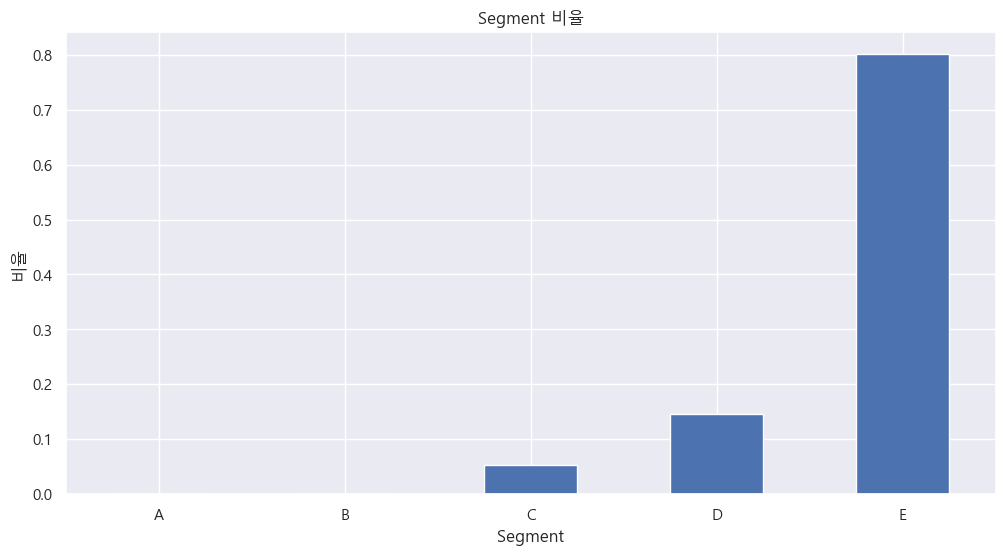

In [9]:
# 각 Segment가 데이터에서 차지하는 비율을 계산하여 막대그래프로 시각화
# 비율(normalized)로 막대그래프 그리기
df_all['Segment'].value_counts(normalize=True).reindex(['A', 'B', 'C', 'D', 'E']).plot(kind='bar')

# 그래프 제목
plt.title("Segment 비율")

# x축 이름
plt.xlabel("Segment")

# y축 이름
plt.ylabel("비율")

# x축 눈금 라벨 회전 설정
plt.xticks(rotation=0)

plt.show()

###  📊 Segment E에 데이터가 몰려 있는 불균형 데이터셋
- 회원 정보에서 확인된 내용

In [11]:
# 결측치 비율 계산
missing_ratio = df_all.isnull().mean()

# 결측치 비율 상위 20개 확인
print(missing_ratio.sort_values(ascending=False).head(20))

RV신청일자           0.813015
RV전환가능여부         0.012280
한도증액후경과월         0.000000
상향가능CA한도금액       0.000000
카드론동의여부          0.000000
월상환론상향가능한도금액     0.000000
일시불ONLY전환가능여부    0.000000
카드이용한도금액_B1M     0.000000
카드이용한도금액_B2M     0.000000
특별한도보유여부_R3M     0.000000
연체감액여부_R3M       0.000000
기준년월             0.000000
한도심사요청건수         0.000000
한도요청거절건수         0.000000
한도심사요청후경과월       0.000000
한도심사거절후경과월       0.000000
시장단기연체여부_R6M     0.000000
시장단기연체여부_R3M     0.000000
시장연체상환여부_R6M     0.000000
시장연체상환여부_R3M     0.000000
dtype: float64


###  📊 20% 이상은 선제거
- RV신청일자           0.813015
- RV전환가능여부         0.012280

In [13]:
# 결측률 계산
missing_ratio = df_all.isnull().mean()

# 결측률이 20% 이상인 컬럼 리스트 추출
cols_with_high_na = missing_ratio[missing_ratio >= 0.2].index.tolist()

# 해당 컬럼들 중 하나라도 결측값이 있는 행 제거
df_all = df_all.dropna(subset=cols_with_high_na)

In [14]:
# 결측값이 존재하는 컬럼 확인 필요 

print(df_all['RV전환가능여부'].value_counts(dropna=False)) 

RV전환가능여부
Z       2188140
N        496170
None       8274
Name: count, dtype: int64


In [15]:
# 'RV전환가능여부' 결측값을 'Z'으로 대체
df_all['RV전환가능여부'] = df_all['RV전환가능여부'].fillna('Z')

### 📊 'RV전환가능여부' 결측값 Z로 대체
- Z가 N에 비해 압도적으로 수가 많고, 결측값은 비교적 적은 수

## ✅ 상관관계 분석

In [18]:
corr = df_all.select_dtypes(include='number').corr()
# 0.9정도면 두 변수는 거의 같은 정보를 가진다고 판단 → 중복
high_corr = np.where(abs(corr) > 0.9)
high_corr_pairs = [(corr.index[x], corr.columns[y]) for x, y in zip(*high_corr) if x != y and x < y]
print("상관관계 0.9 이상 변수쌍:", high_corr_pairs)

상관관계 0.9 이상 변수쌍: [('카드이용한도금액', 'CA한도금액'), ('카드이용한도금액', '카드이용한도금액_B1M'), ('카드이용한도금액', '카드이용한도금액_B2M'), ('CA한도금액', '카드이용한도금액_B1M'), ('CA한도금액', '카드이용한도금액_B2M'), ('CA이자율_할인전', 'RV현금서비스이자율_할인전'), ('상향가능한도금액', '상향가능CA한도금액'), ('카드이용한도금액_B1M', '카드이용한도금액_B2M'), ('한도요청거절건수', '한도심사거절후경과월')]


<Axes: >

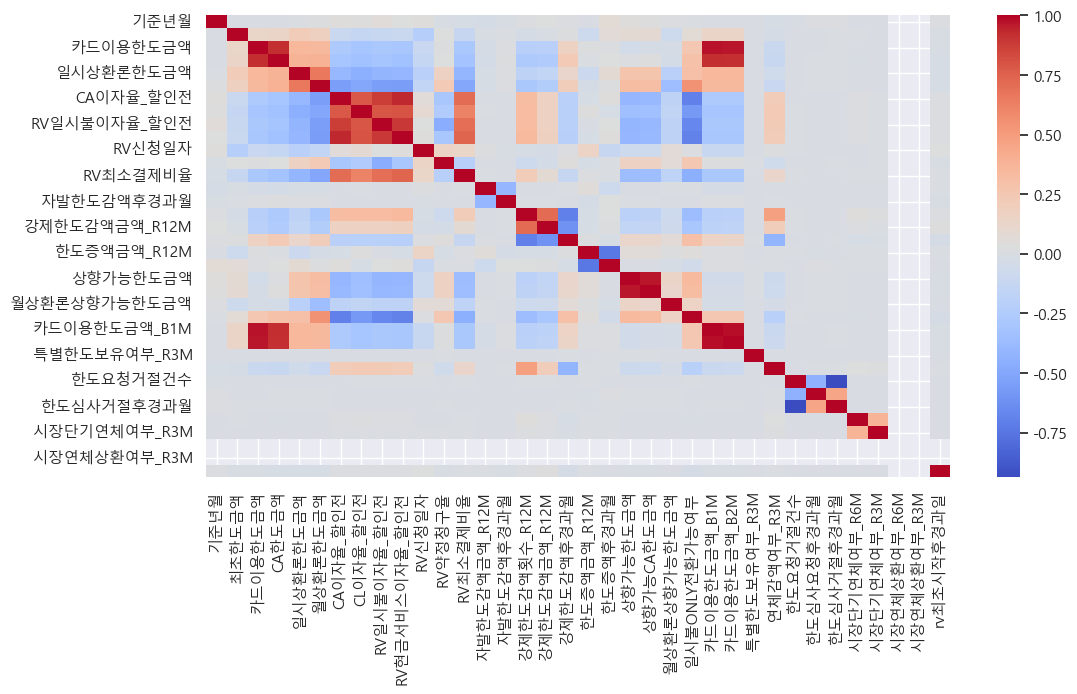

In [19]:
sns.heatmap(corr, cmap='coolwarm')

## ✅ 주요 피처 확인

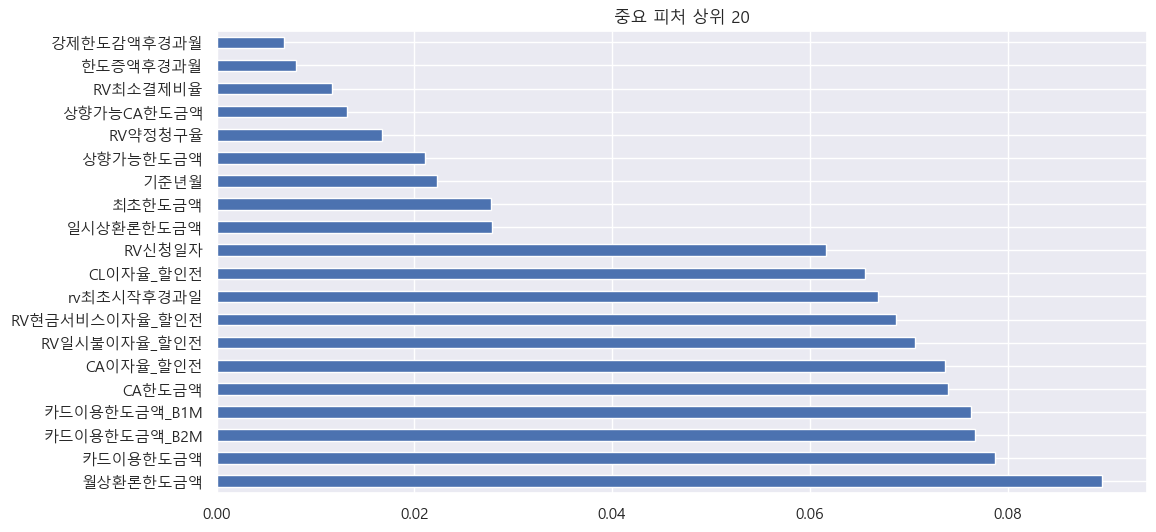

In [21]:
X = df_all.drop(columns=['Segment', 'ID']) # ✅ 예측에 불필요하거나 타겟인 열 제거
y = LabelEncoder().fit_transform(df_all['Segment']) # ✅ 문자열을 숫자로 변환

X = pd.get_dummies(X)  # 범주형 인코딩
model = RandomForestClassifier()
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(20).plot(kind='barh')
plt.title("중요 피처 상위 20")
plt.show()

In [22]:
# 중요 피처 상위 20개
top_cols = [
    '월상환론한도금액',
    '카드이용한도금액',
    '카드이용한도금액_B1M',
    '카드이용한도금액_B2M',
    'CA이자율_할인전',
    'CA한도금액',
    'RV일시불이자율_할인전',
    'RV현금서비스이자율_할인전',
    'rv최초시작후경과일',
    'CL이자율_할인전',
    'RV신청일자',
    '최초한도금액',
    '일시상환론한도금액',
    '기준년월',
    '상향가능한도금액',
    'RV약정청구율',
    '상향가능CA한도금액',
    'RV최소결제비율',
    '한도증액후경과월',
    '강제한도감액후경과월'
]

# 불필요하다고 판단된 변수
drop_cols = [
    'CA한도금액', # 카드이용한도금액과 상관관계가 큼
    '카드이용한도금액_B1M', '카드이용한도금액_B2M', # 카드이용한도금액과 상관관계가 크고 흐름이 유사함
    'RV현금서비스이자율_할인전', # CA이자율 할인전과 상관관계가 큼
    '월상환론한도금액', # 영향 미미
    'RV일시불이자율_할인전', # 영향 미미
    '기준년월', # 영향 미미
    '최초한도금액', # 영향 미미
    '일시상환론한도금액', # 영향 미미
    '한도증액후경과월', # 영향 미미
    '강제한도감액후경과월' # 영향 미미
]

# 최종 선택된 피처 목록 (Segment 포함)
selected_cols = top_cols + ['Segment']

# 선택된 컬럼만 필터링
df_selected = df_all[selected_cols]

# 필요 없는 피처 제거
df_selected = df_selected.drop(columns=[col for col in drop_cols if col in df_selected.columns])

# 결과 확인
print("선택된 컬럼 수:", len(df_selected.columns))
print("컬럼 목록:", df_selected.columns.tolist())


선택된 컬럼 수: 10
컬럼 목록: ['카드이용한도금액', 'CA이자율_할인전', 'rv최초시작후경과일', 'CL이자율_할인전', 'RV신청일자', '상향가능한도금액', 'RV약정청구율', '상향가능CA한도금액', 'RV최소결제비율', 'Segment']


### ✅ 카드이용한도금액 vs Segment 분포 비교

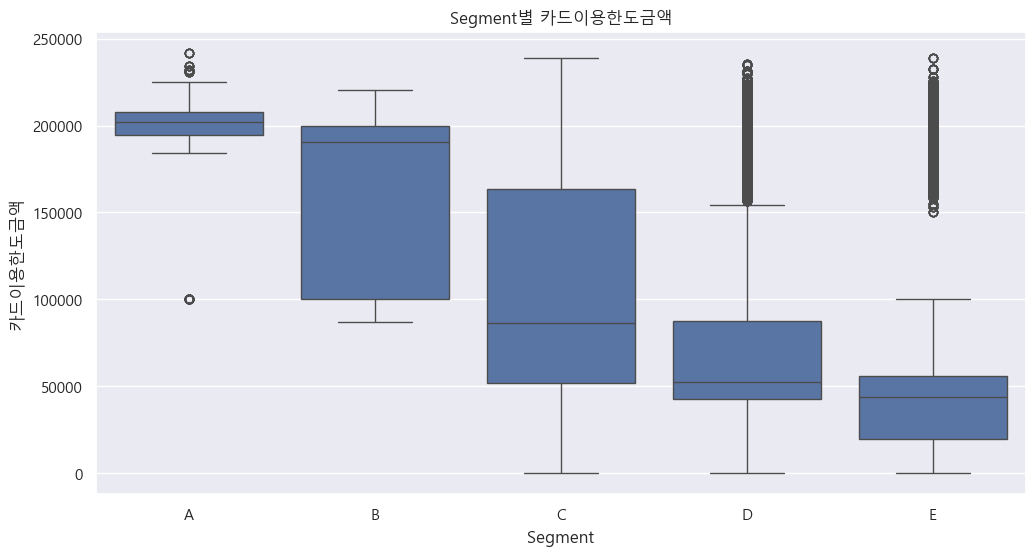

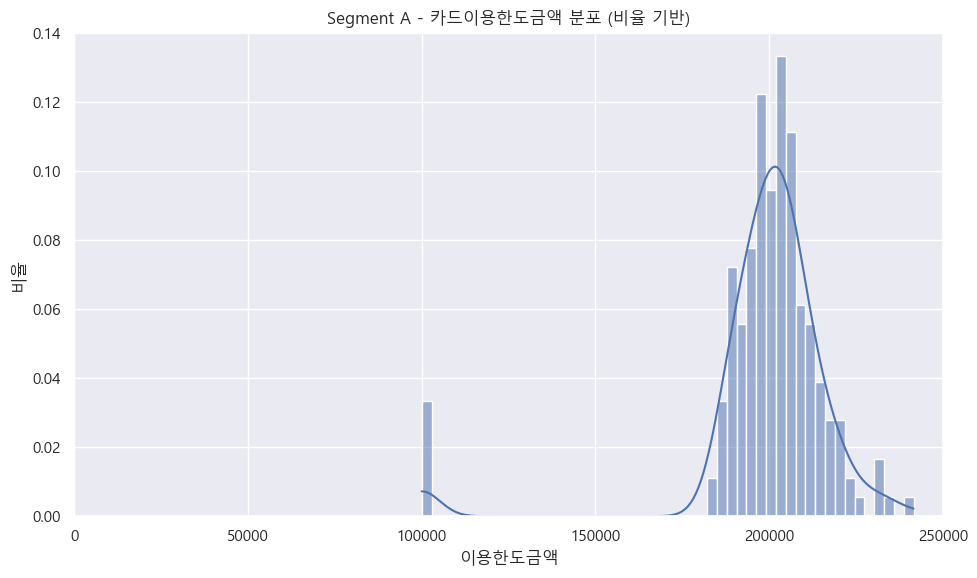

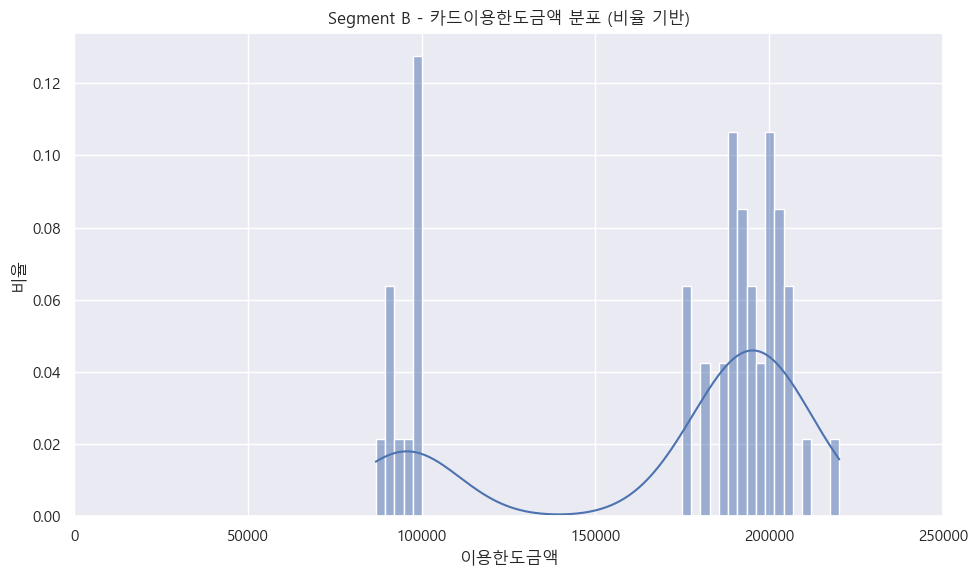

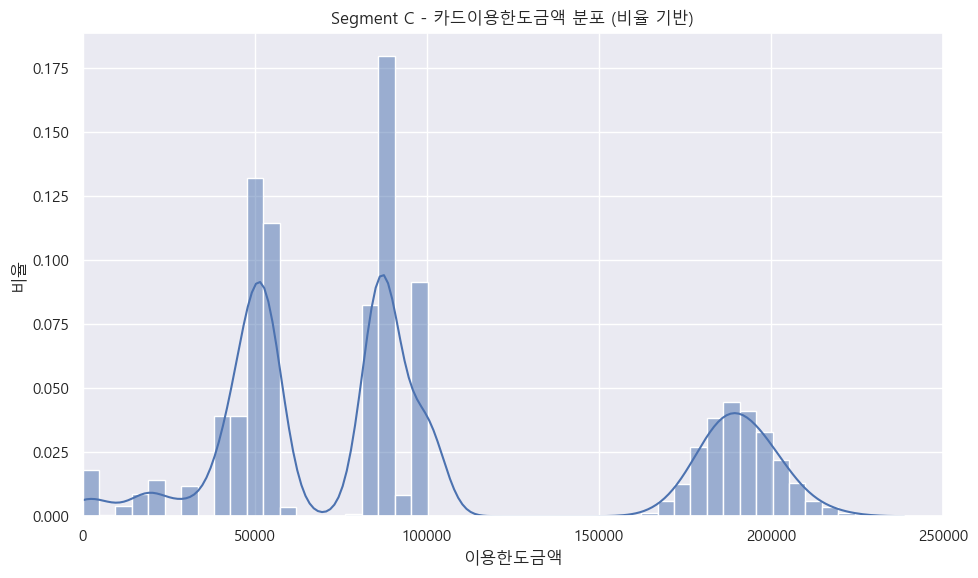

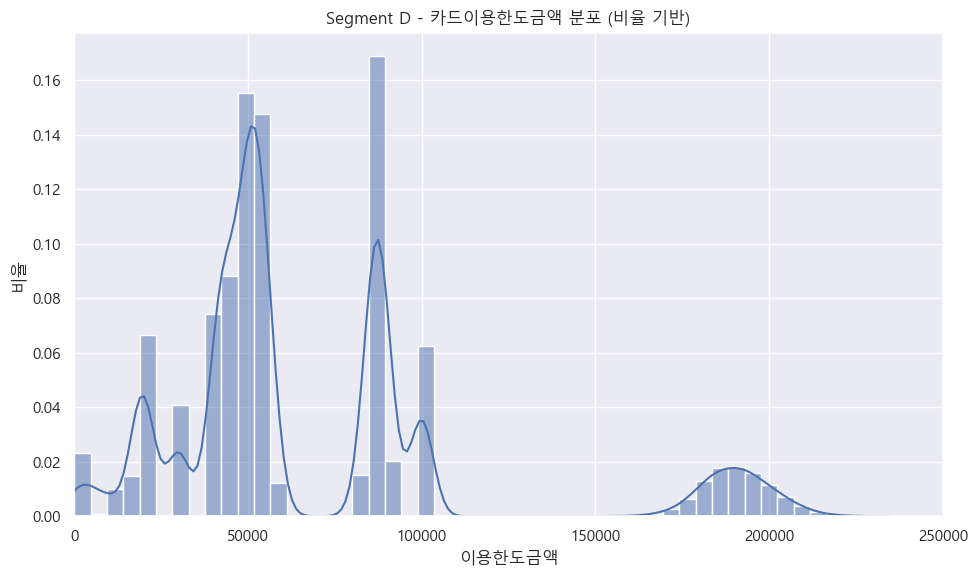

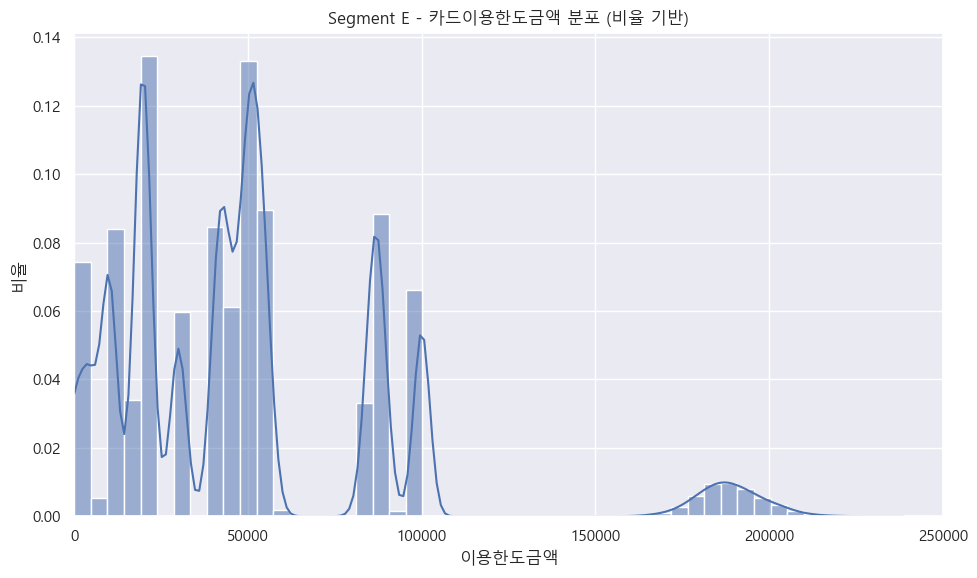

In [24]:
# Boxplot을 이용하여 Segment별 카드이용한도금액의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 카드이용한도금액
sns.boxplot(data=df_all, x='Segment', y='카드이용한도금액', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 카드이용한도금액")
plt.show()

# Segment별 히스토그램을 이용하여 카드이용한도금액의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
x_min = 0
x_max = 250000


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='카드이용한도금액', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.title(f"Segment {seg} - 카드이용한도금액 분포 (비율 기반)")
    plt.xlabel("이용한도금액")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()

###  📊 Segment가 A, B의 숫자가 너무 작음 

- Y축을 비율, X축을 최소, 최대로 설정해 확인

###  📊 Segment가 A > E 갈수록 이용한도금액이 낮아지는 경향이 뚜렷함 

- 고객이 신용카드로 결제할 수 있는 최대 금액이 낮아진다는 뜻

### 📊 '카드이용한도금액_B1M', '카드이용한도금액_B2M' 제거

- 카드이용한도금액과 유사한 경향을 보임
- 상관관계가 높은 것으로 보여 제거

### ✅ 월상환론한도금액 vs Segment 분포 비교

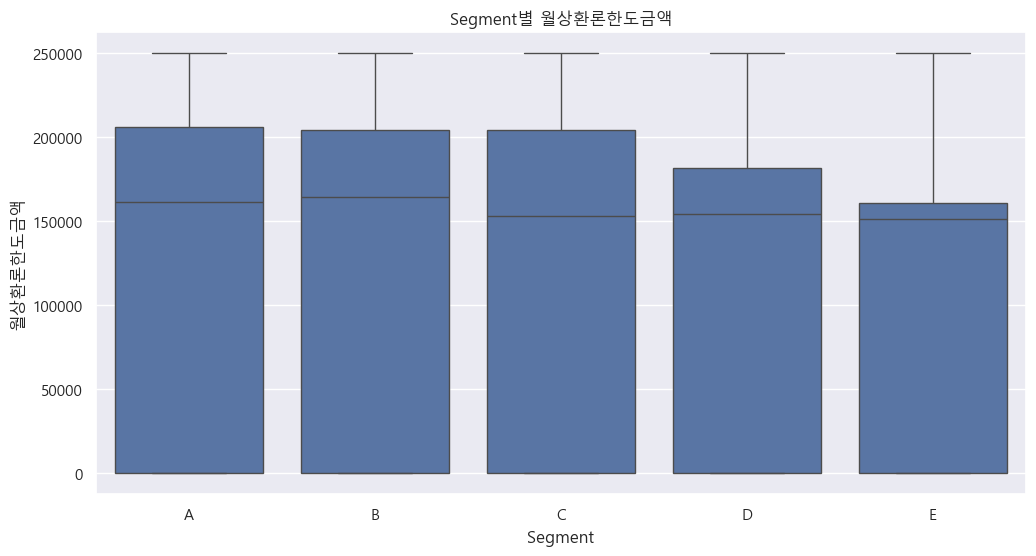

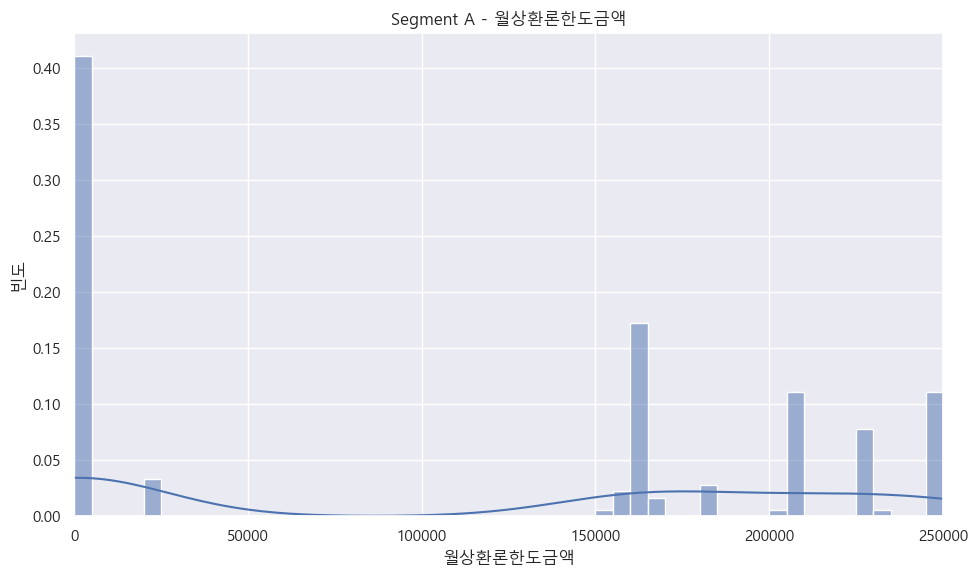

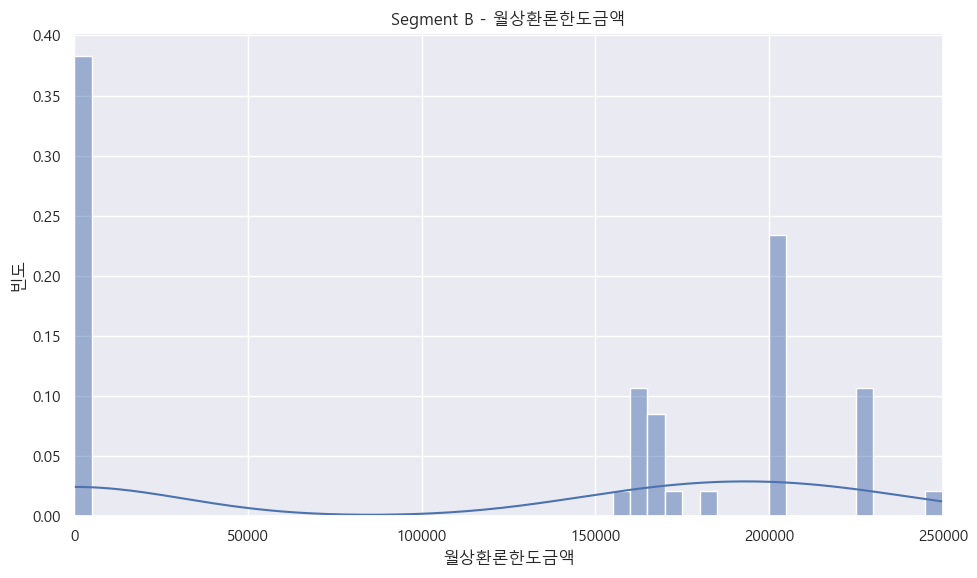

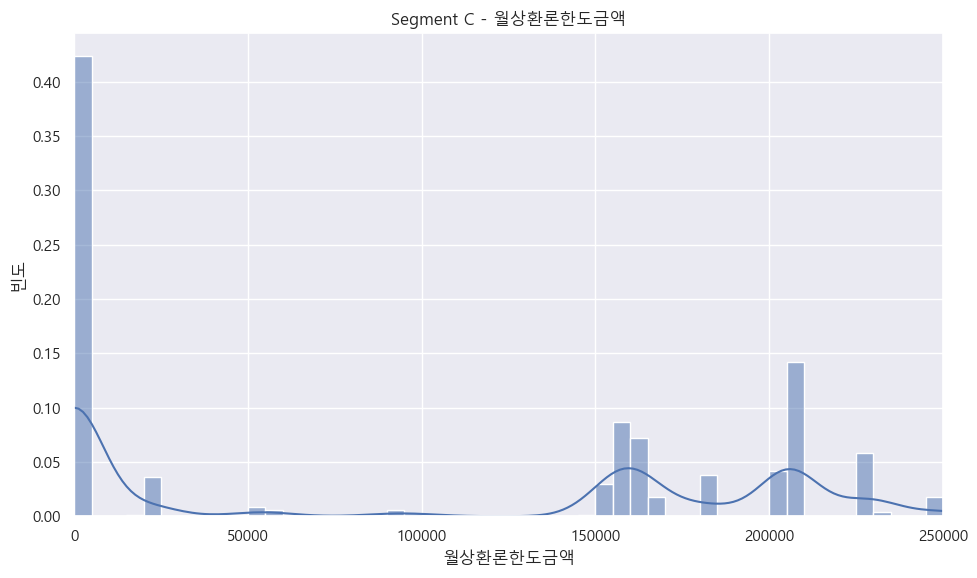

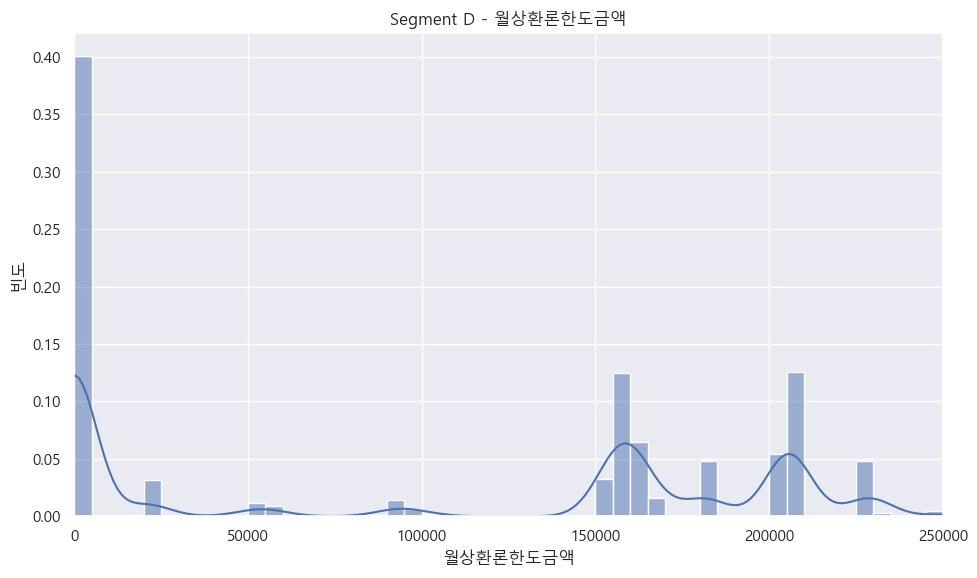

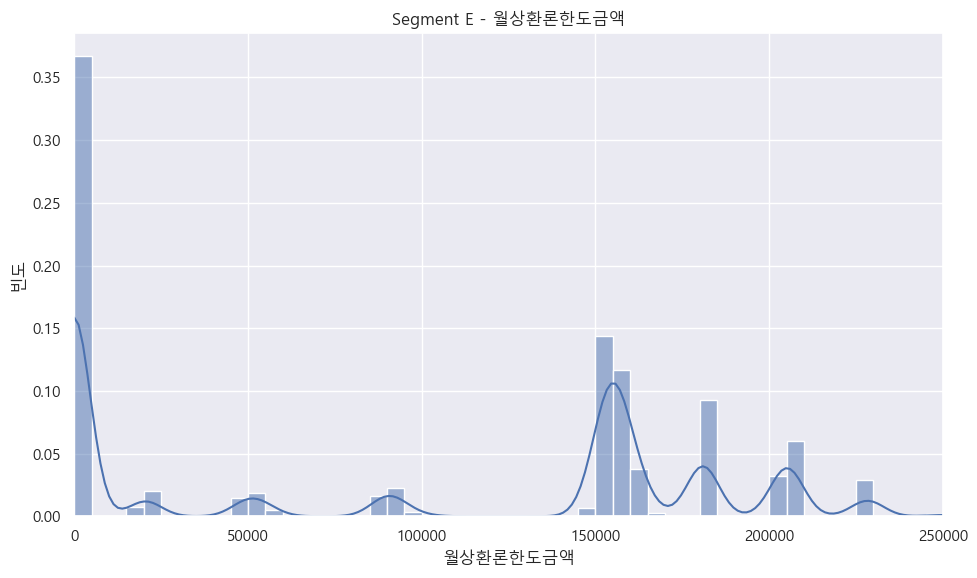

,mean,median,std,min,max,count
Segment,,,,,,
A,111851.405556,161405.0,102063.790590,0,250000,1080
B,119729.531915,164150.0,96722.847144,0,249977,282
C,99468.866984,153098.0,94848.812722,0,250000,173754
D,100442.268742,154345.0,91433.055348,0,250000,546390
E,97183.229142,151357.0,83913.162445,0,250000,1971078


In [28]:
# Boxplot을 이용하여 Segment별 카드이용한도금액의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 카드이용한도금액
sns.boxplot(data=df_all, x='Segment', y='월상환론한도금액', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 월상환론한도금액")
plt.show()

# Segment별 히스토그램을 이용하여 카드이용한도금액의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
x_min = 0
x_max = 250000


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='월상환론한도금액', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.title(f"Segment {seg} - 월상환론한도금액")
    plt.xlabel("월상환론한도금액")
    plt.ylabel("빈도")
    plt.tight_layout()
    plt.show()

df_all.groupby('Segment')['월상환론한도금액'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])

### 📊 월상환론한도금액은 세그먼트별 별다른 흐름의 차이가 없음

- 제거필요

### ✅ CA이자율_할인전 vs Segment 분포 비교

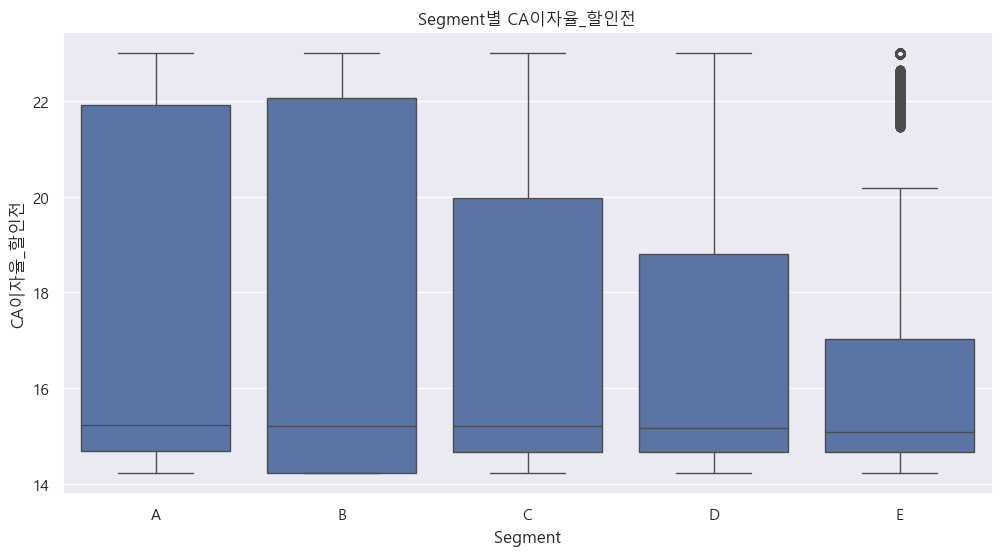

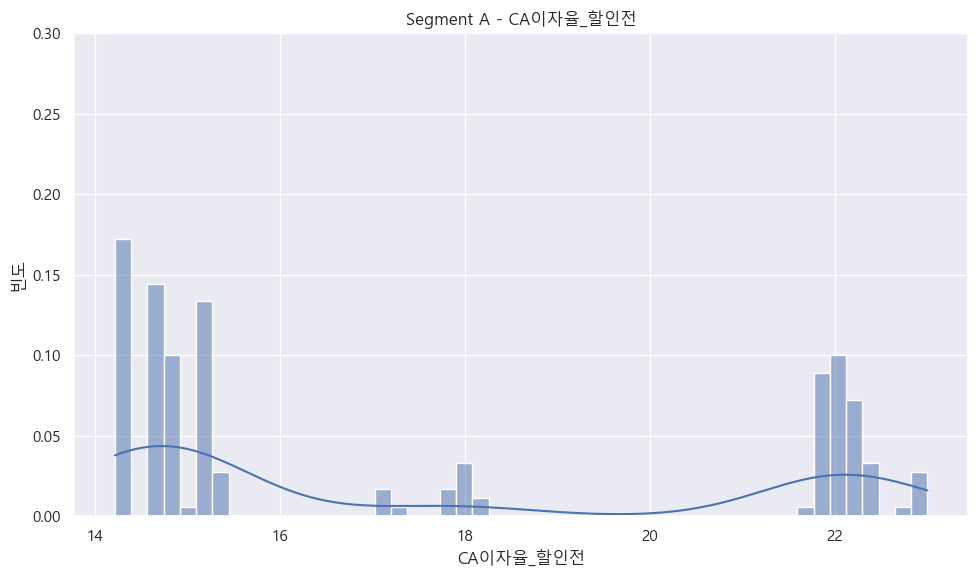

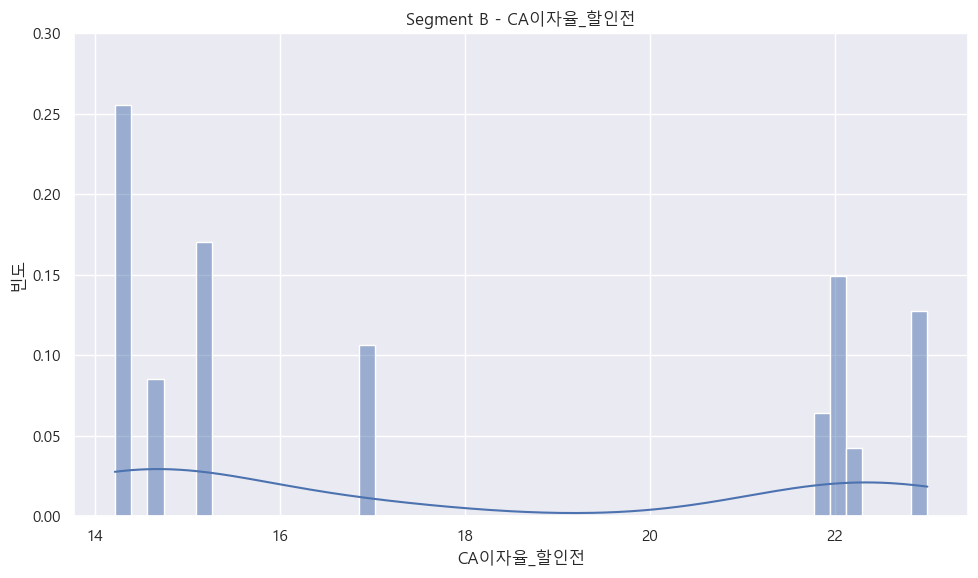

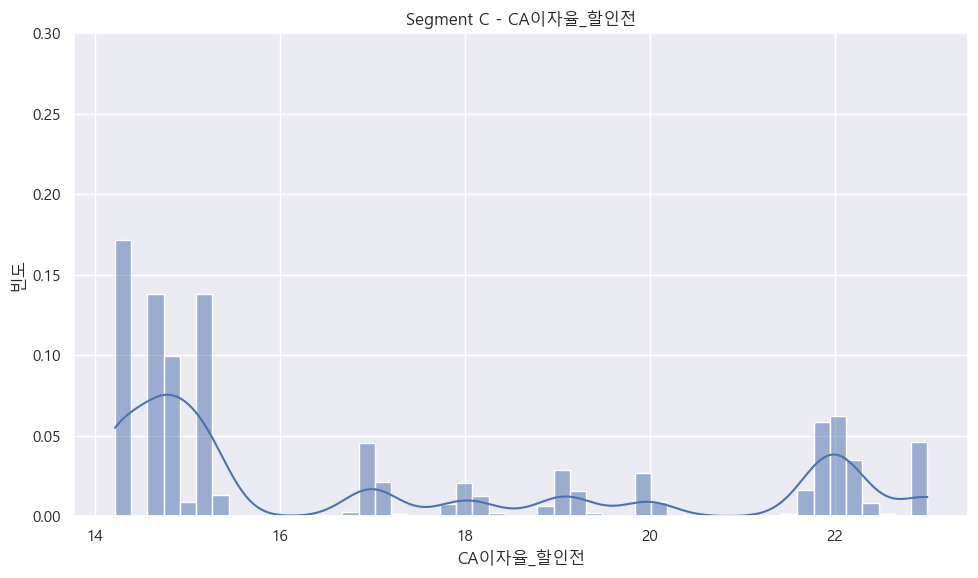

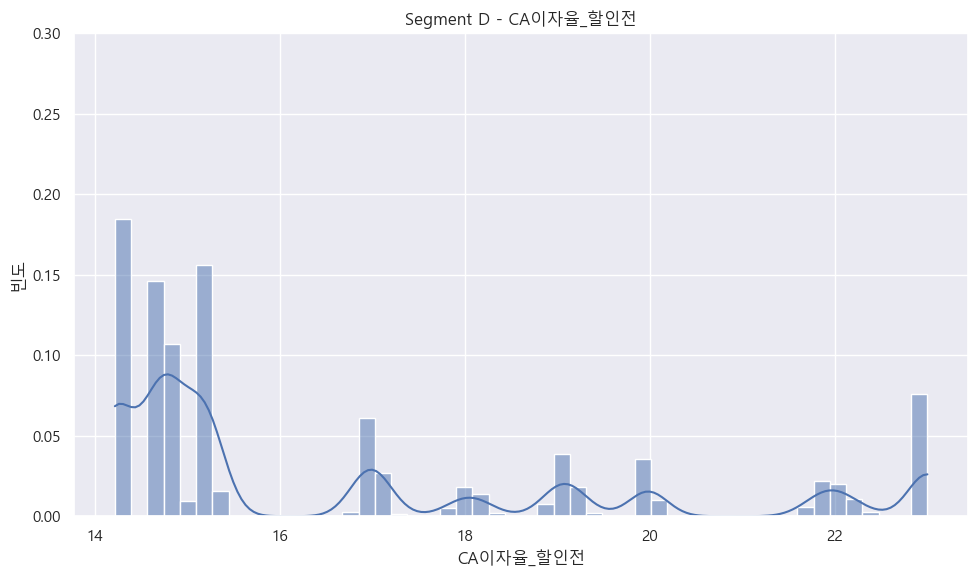

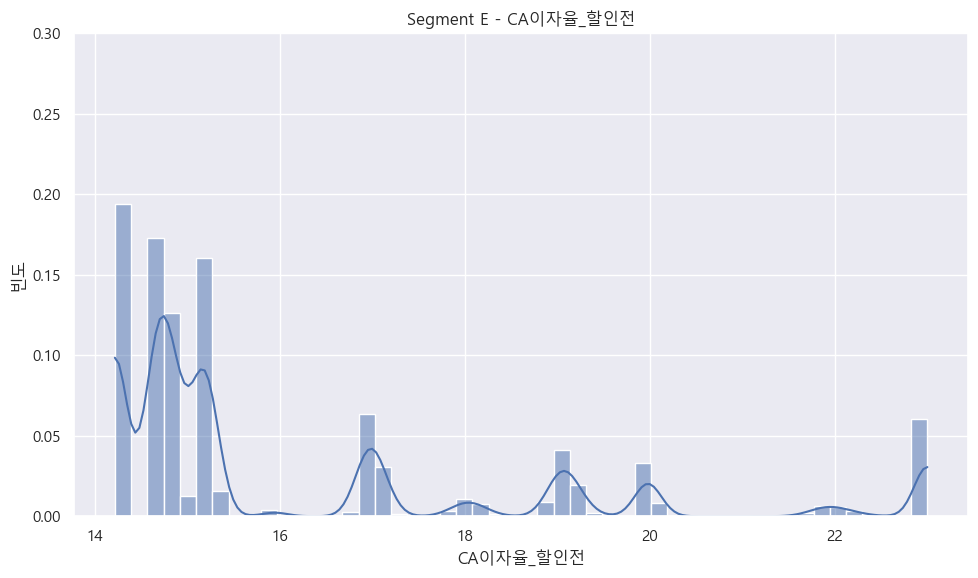

In [31]:
# Boxplot을 이용하여 Segment별 CA이자율_할인전의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 CA이자율_할인전
sns.boxplot(data=df_all, x='Segment', y='CA이자율_할인전', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 CA이자율_할인전")
plt.show()


# Segment별 히스토그램을 이용하여 카드이용한도금액의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000

# y축 공통 범위 설정(원하는 범위로 조정)
y_min = 0
y_max = 0.3



for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='CA이자율_할인전', bins=50, kde=True,
                stat='probability')


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.ylim(y_min,y_max)
    plt.title(f"Segment {seg} - CA이자율_할인전")
    plt.xlabel("CA이자율_할인전")
    plt.ylabel("빈도")
    plt.tight_layout()
    plt.show()

### 📊 CA이자율_할인전

- 세그먼트별 흐름에 분명한 차이는 없음
- 세그먼트 B의 경우 타 세그먼트에 비해 14-16사이의 비율이 조금 높게 나타는 것으로 확인
- 다만 세그먼트 B의 데이터 자체가 수가 적어서 14-16사이에 몰려 그렇게 보이는 것일 수도 있음
- A, B의 분산이 큰데, 데이터 수가 적어서 그런 것으로 판단

### ✅ RV일시불이자율_할인전 vs Segment 분포 비교

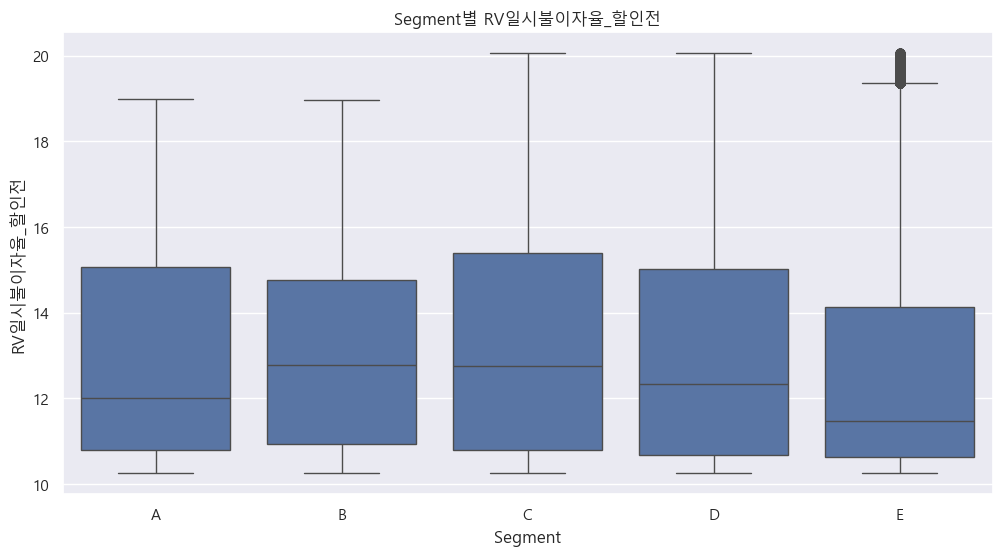

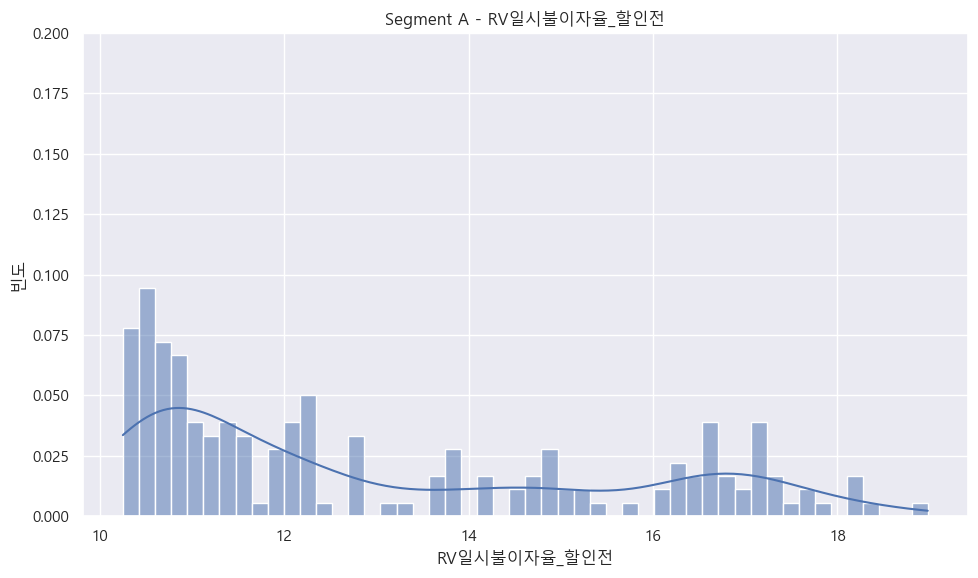

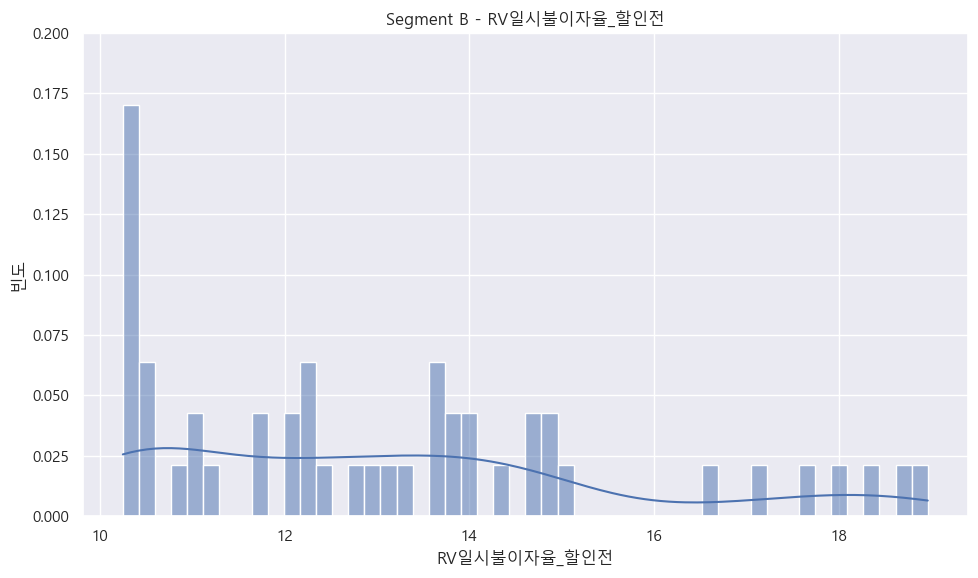

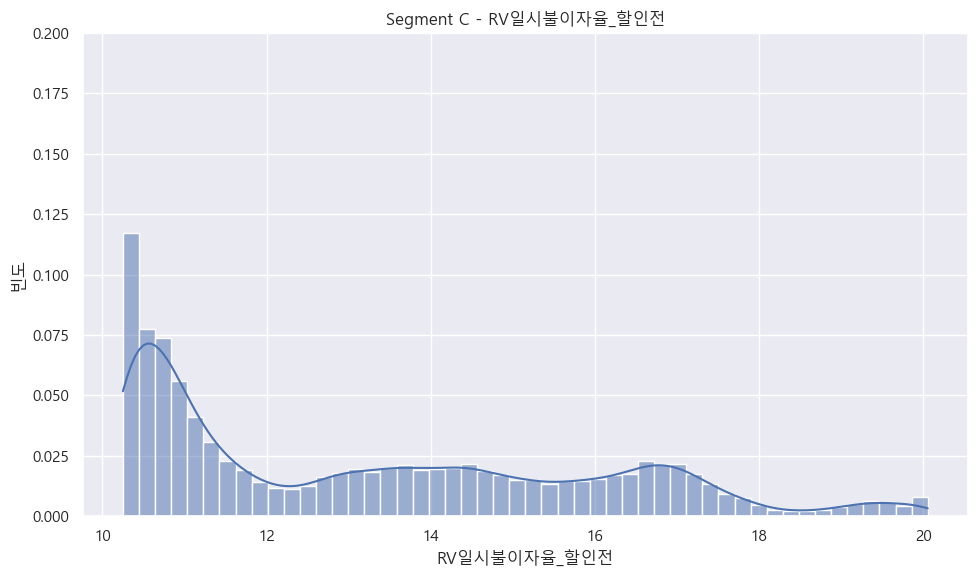

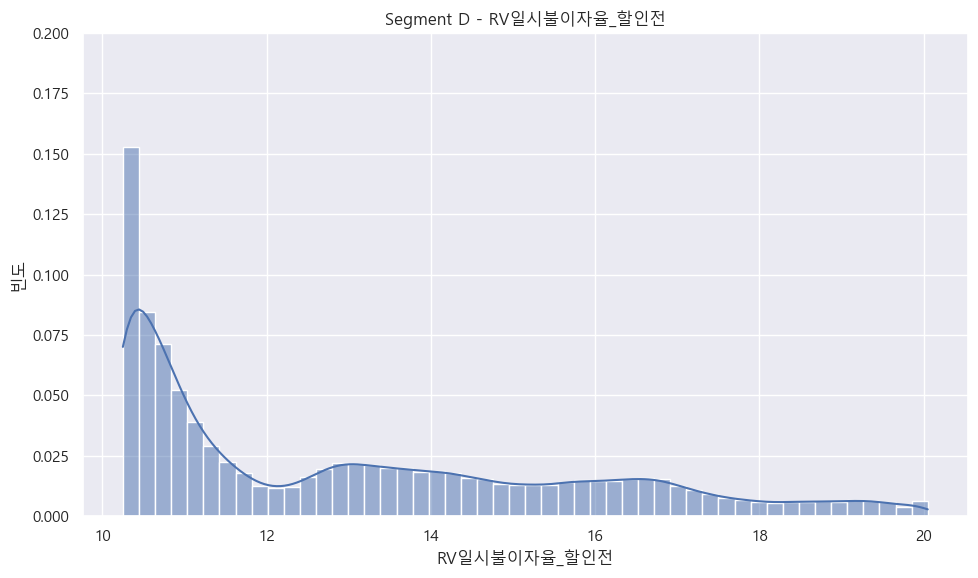

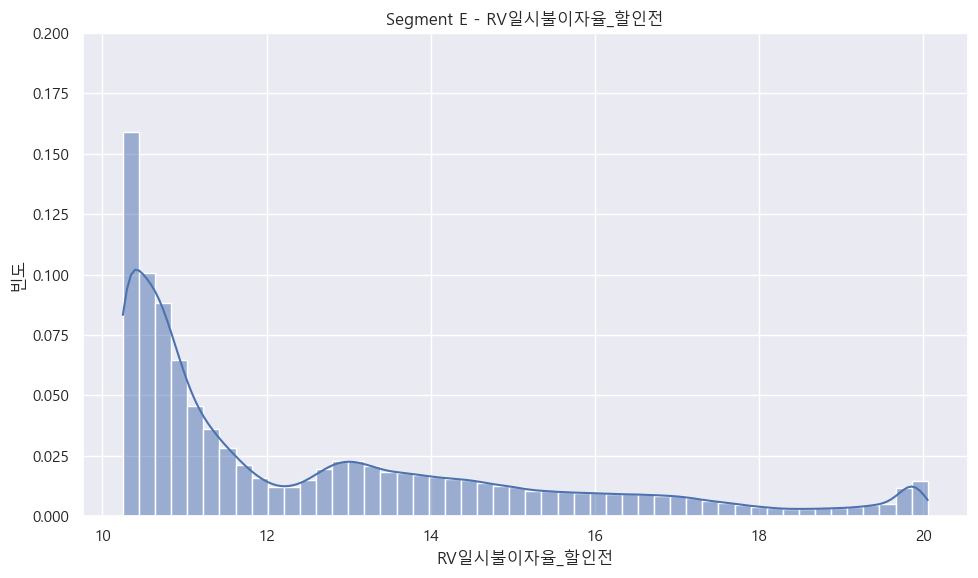

In [34]:
# Boxplot을 이용하여 Segment별 RV일시불이자율_할인전의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 CA이자율_할인전
sns.boxplot(data=df_all, x='Segment', y='RV일시불이자율_할인전', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 RV일시불이자율_할인전")
plt.show()

# Segment별 히스토그램을 이용하여 카드이용한도금액의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000
y_min = 0
y_max = 0.2

for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='RV일시불이자율_할인전', bins=50, kde=True,
                stat='probability')


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.ylim(y_min,y_max)
    plt.title(f"Segment {seg} - RV일시불이자율_할인전")
    plt.xlabel("RV일시불이자율_할인전")
    plt.ylabel("빈도")
    plt.tight_layout()
    plt.show()

### 📊 RV일시불이자율_할인전 제거

- 세그먼트별 흐름에 차이가 없음

### ✅ rv최초시작후경과일 vs Segment 분포 비교

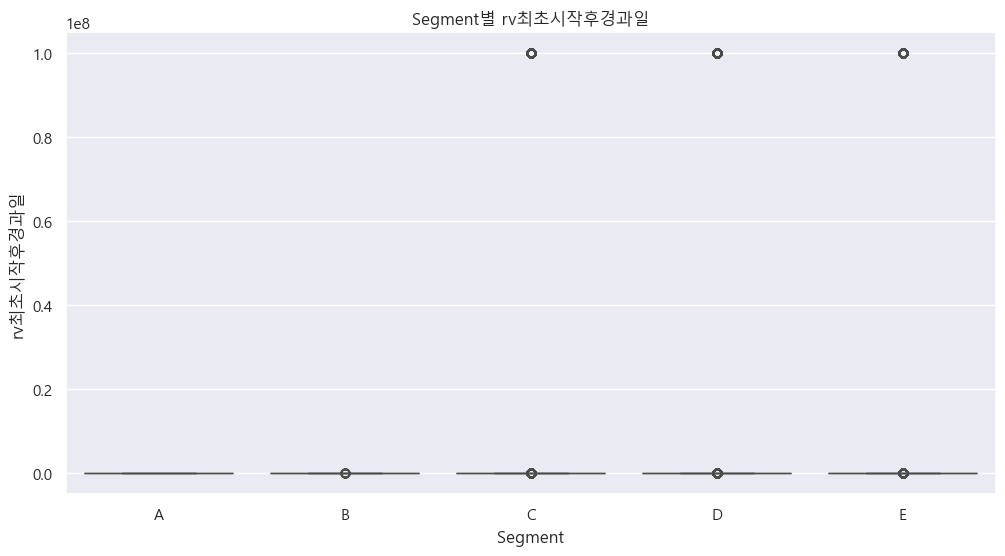

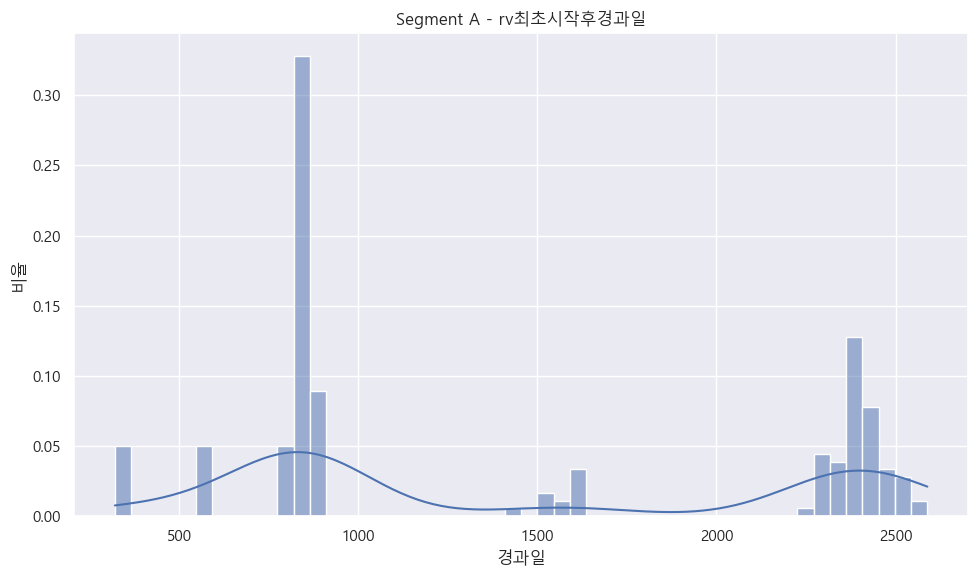

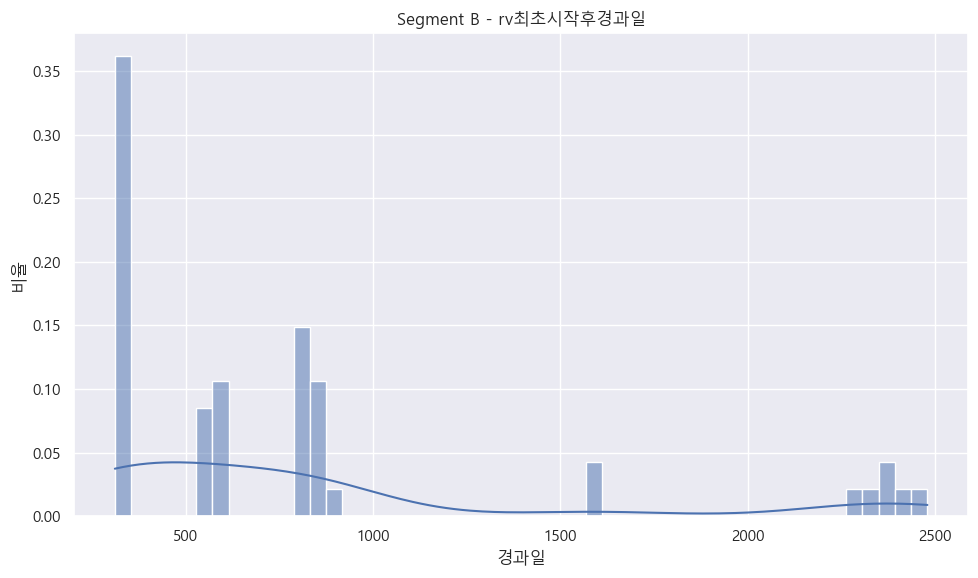

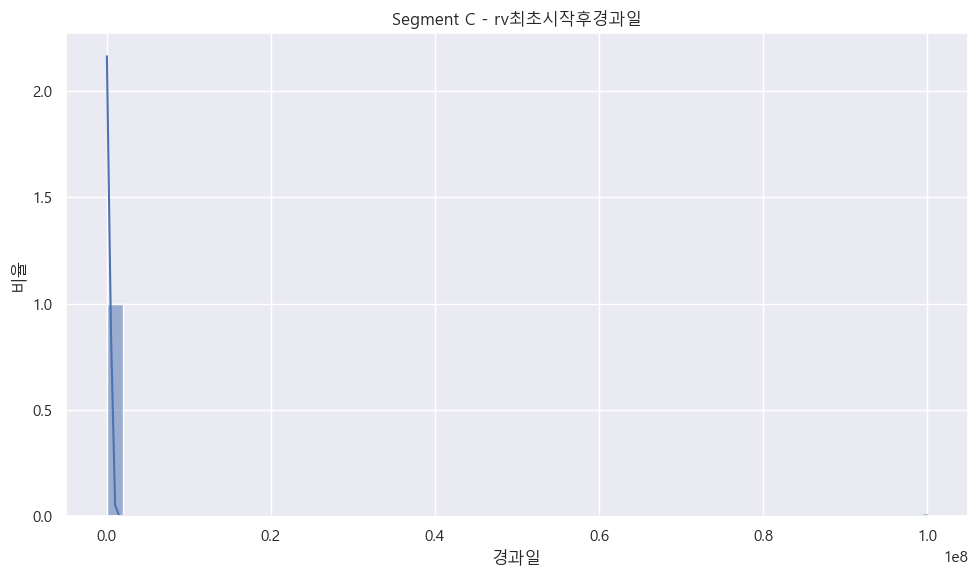

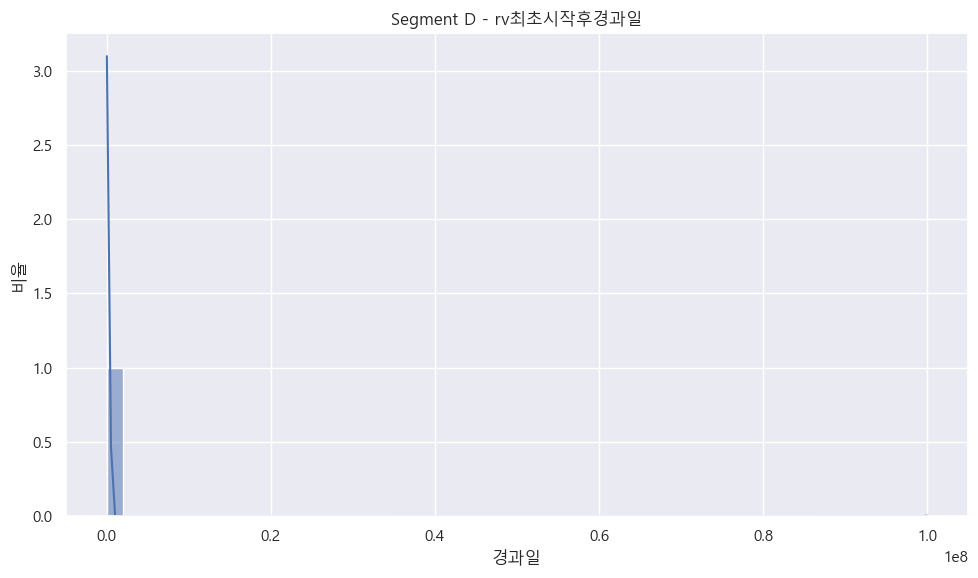

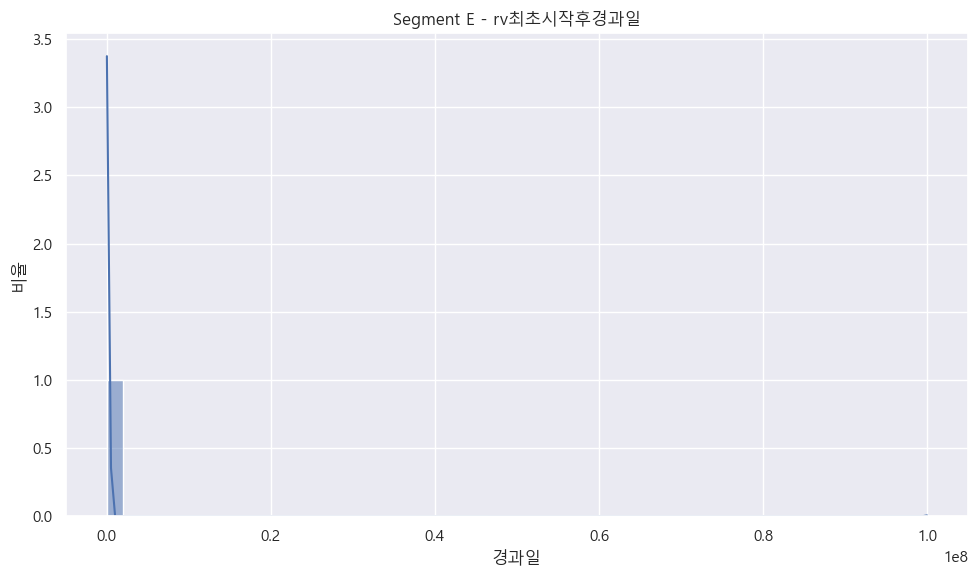

In [37]:
# Boxplot을 이용하여 Segment별 rv최초시작후경과일의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 rv최초시작후경과일
sns.boxplot(data=df_all, x='Segment', y='rv최초시작후경과일', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 rv최초시작후경과일")
plt.show()


# Segment별 히스토그램을 이용하여 rv최초시작후경과일의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='rv최초시작후경과일', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.title(f"Segment {seg} - rv최초시작후경과일")
    plt.xlabel("경과일")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()

### 📊 rv최초시작후경과일은 대부분 0, 극단치가 존재하는 것으로 판단

- 박스플롯이 찌그러져 있음
- 로그변환해서 다시 파악 필요

### 📊 신규, 장기 사용자 분포 데이터로 활용 가능

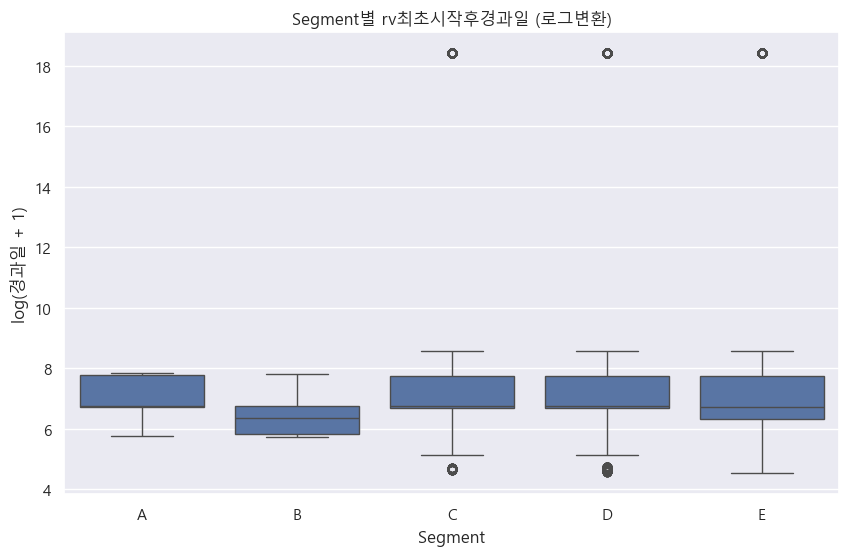

In [39]:
df_all['log_rv경과일'] = np.log1p(df_all['rv최초시작후경과일'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='Segment', y='log_rv경과일', order=['A', 'B', 'C', 'D', 'E'])
plt.title("Segment별 rv최초시작후경과일 (로그변환)")
plt.ylabel("log(경과일 + 1)")
plt.show()

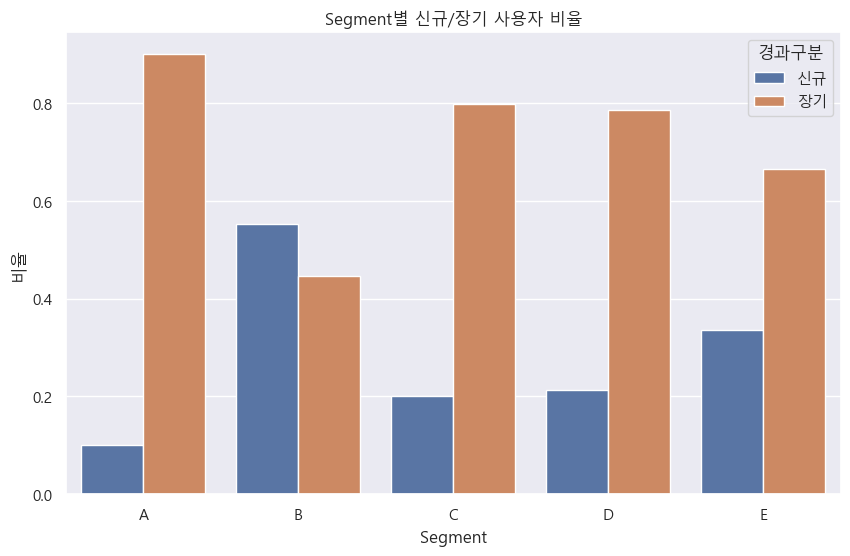

In [40]:
# 730일(2년) 이하 → 신규, 이상 → 장기
df_all['경과구분'] = df_all['rv최초시작후경과일'].apply(lambda x: '신규' if x <= 730 else '장기')

# 세그먼트별 신규/장기 분포
segment_dist = df_all.groupby(['Segment', '경과구분']).size().reset_index(name='count')

# 전체 비율로 변환
segment_dist['ratio'] = segment_dist.groupby('Segment')['count'].transform(lambda x: x / x.sum())

# 막대그래프
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_dist, x='Segment', y='ratio', hue='경과구분')
plt.title("Segment별 신규/장기 사용자 비율")
plt.ylabel("비율")
plt.show()

### 📊 Segment A는 전체적으로 고객 충성도가 높고, 리볼빙도 오랜 기간 이용한 사용자 중심

### 📊 Segment B는 이례적으로 신규 고객 비중이 높음
- 최근 유입 리볼빙 고객 많음

### 📊 Segment E는 앞선 인사이트와 결합하여 보면
- 활동 적고, 입회 경과 짧음
- 리볼빙은 오래된 고객 많음
- 즉, 신규 가입자는 많지만 과거 리볼빙 경험이 있는 저활동 고객 다수

### ✅ CL이자율_할인전 vs Segment 분포 비교

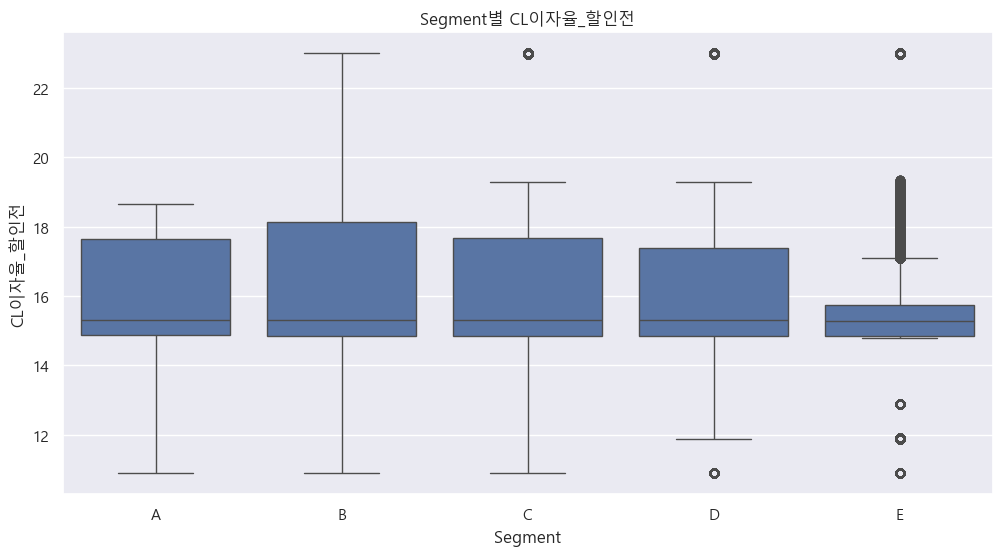

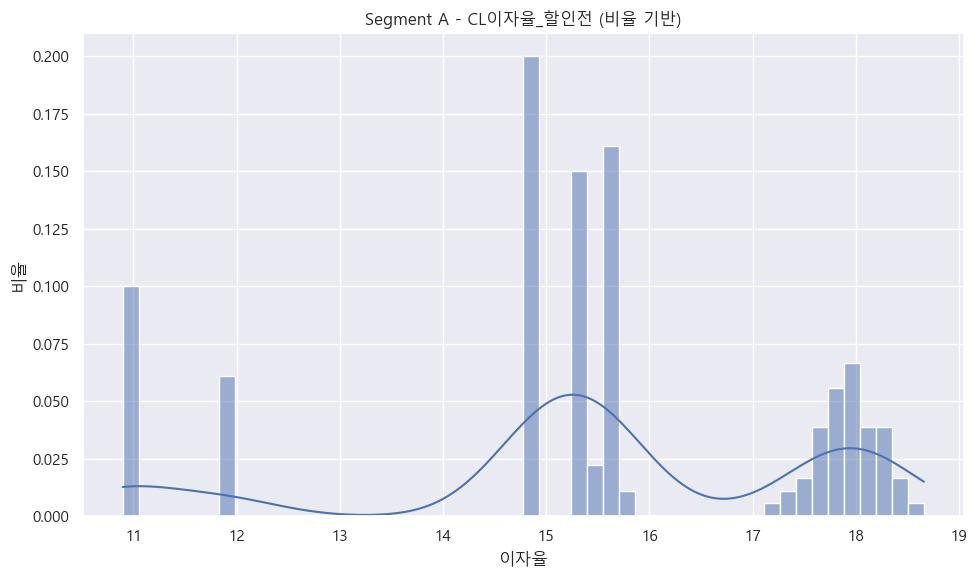

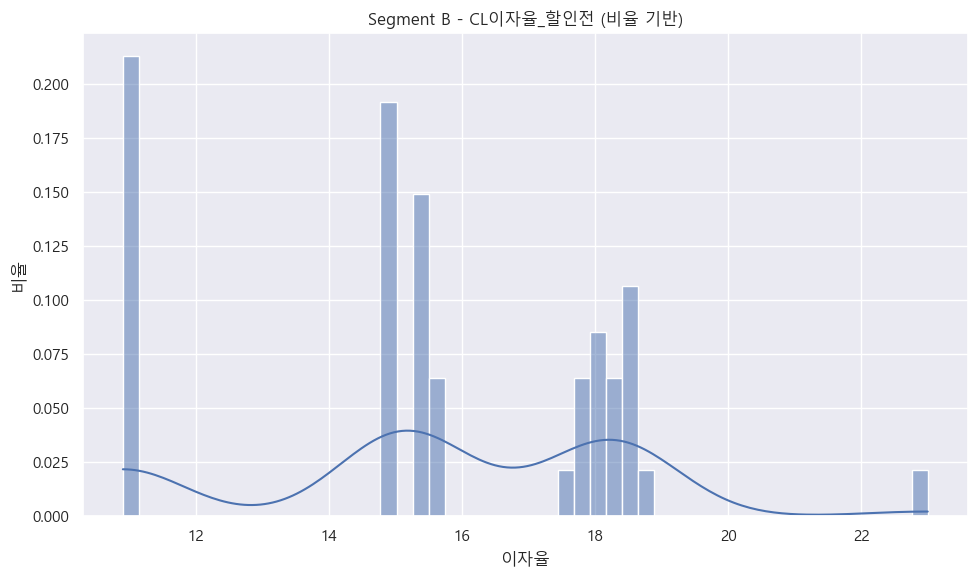

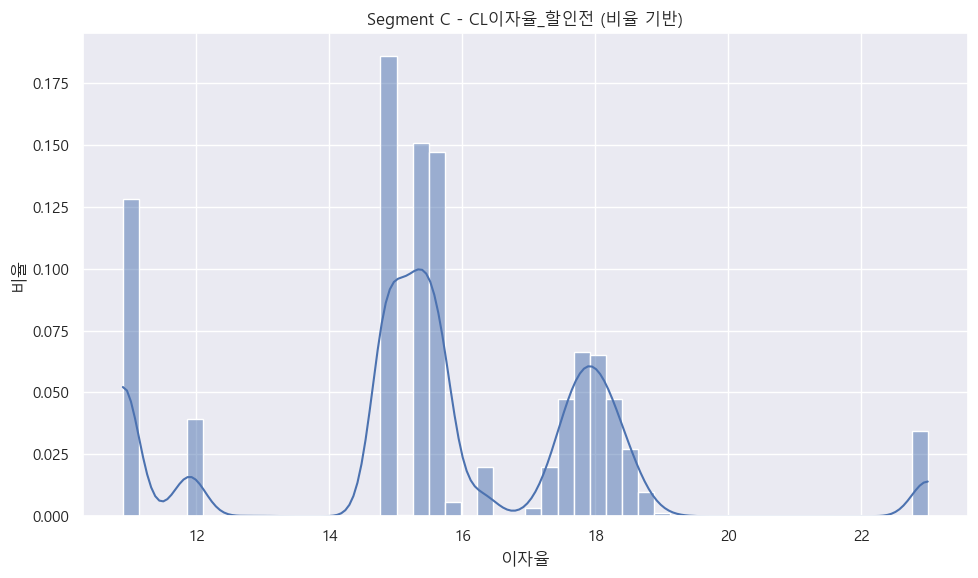

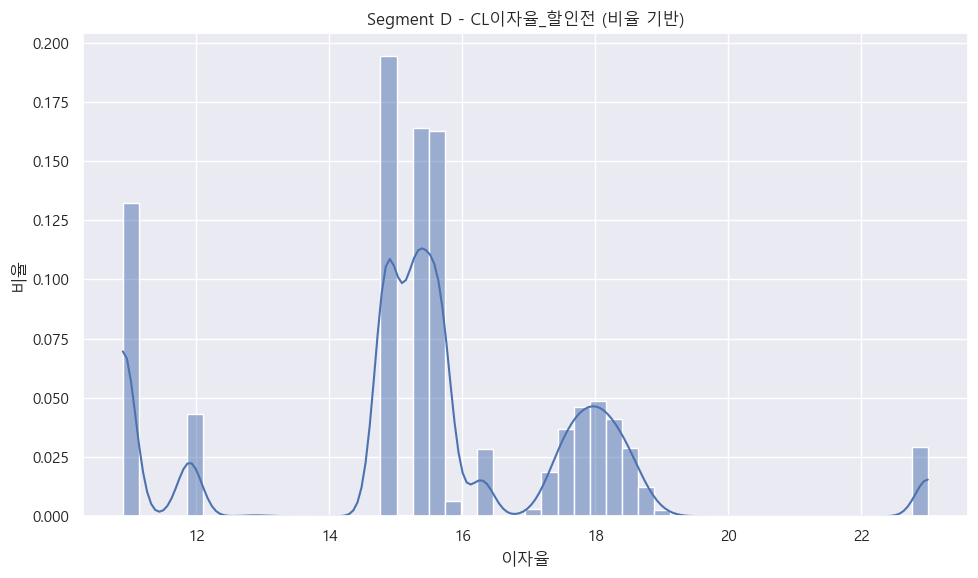

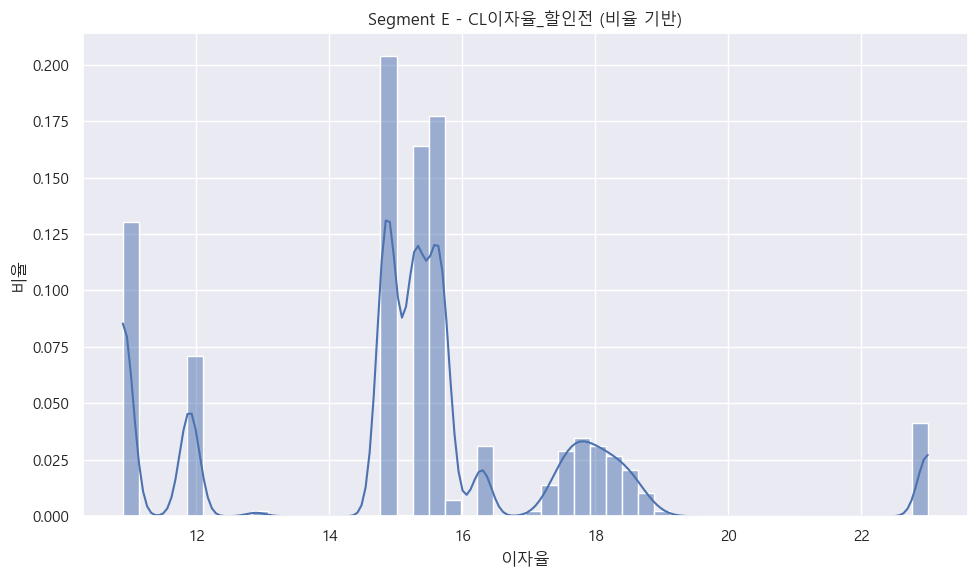

In [43]:
# Boxplot을 이용하여 Segment별 CL이자율_할인전의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 CL이자율_할인전
sns.boxplot(data=df_all, x='Segment', y='CL이자율_할인전', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 CL이자율_할인전")
plt.show()


# Segment별 히스토그램을 이용하여 CL이자율_할인전의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='CL이자율_할인전', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.title(f"Segment {seg} - CL이자율_할인전 (비율 기반)")
    plt.xlabel("이자율")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()

### 📊 분명한 흐름을 파악하기 어렵지만, 세그먼트 별 차이가 조금씩 존재
- CA = Cash Advance (현금서비스) 단기 자금 성격
- CL = Card Loan (카드론) 장기 자금 성격

### ✅ RV신청일자 vs Segment 분포 비교

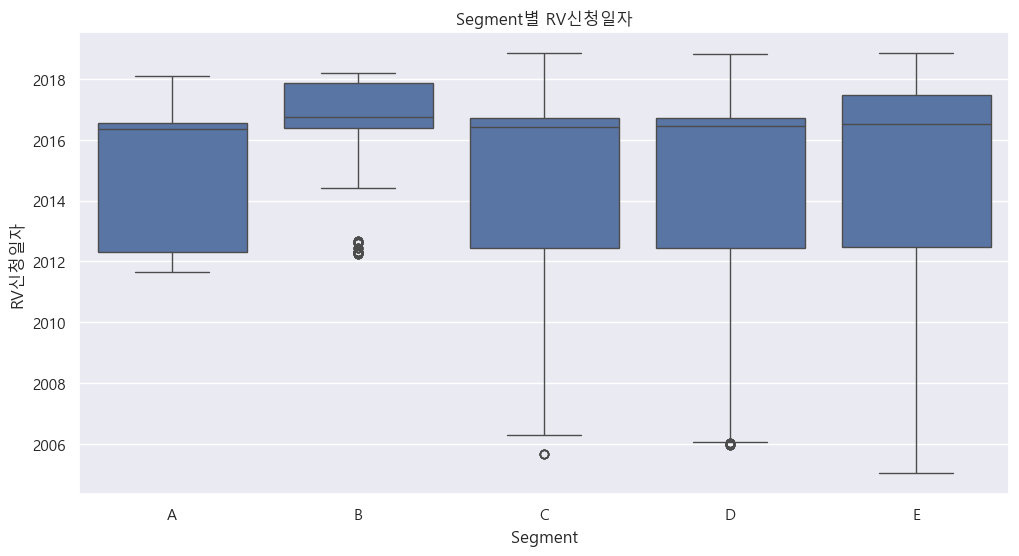

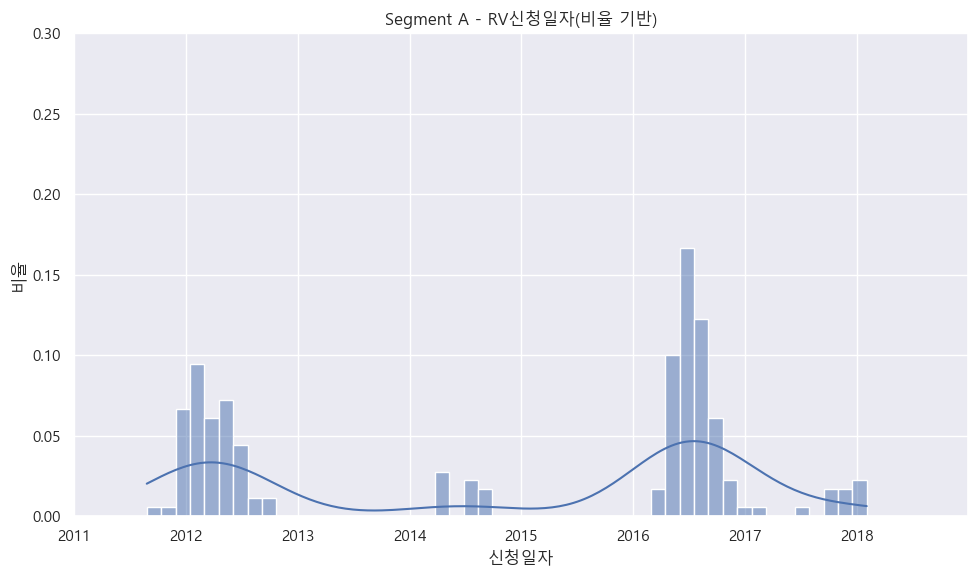

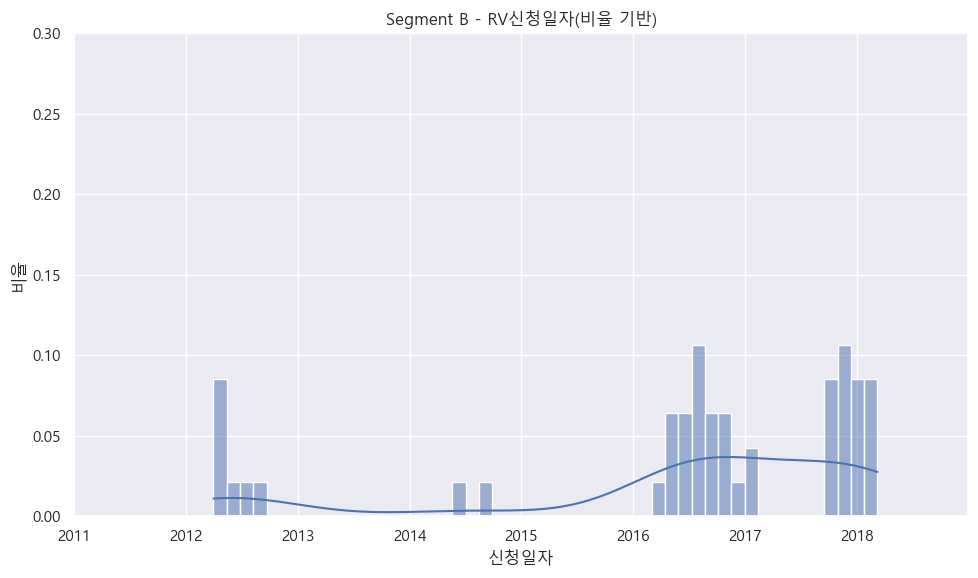

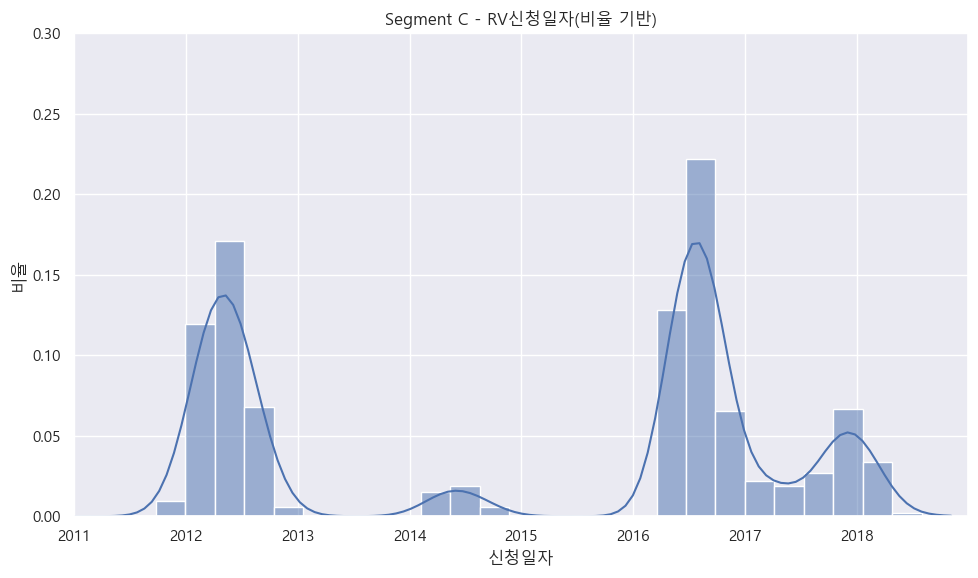

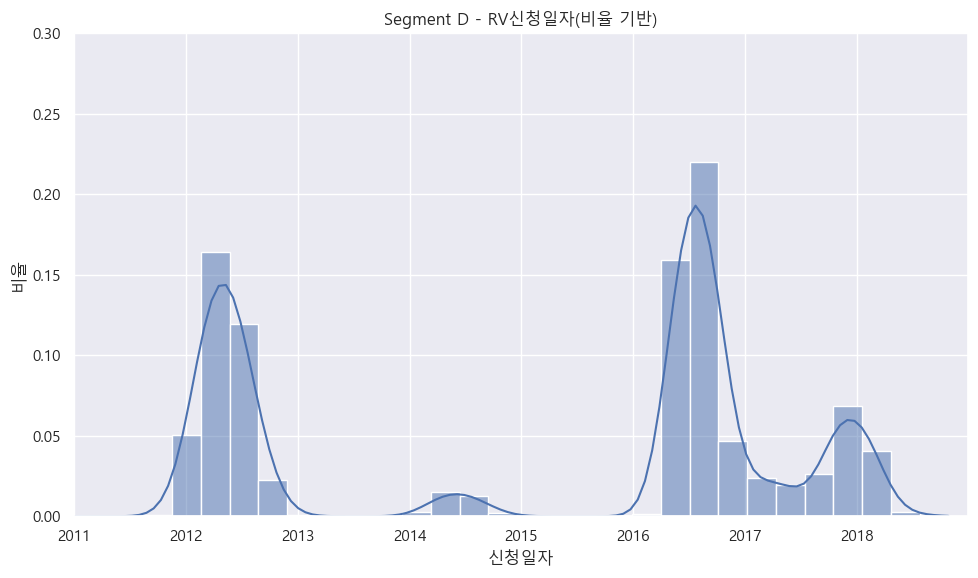

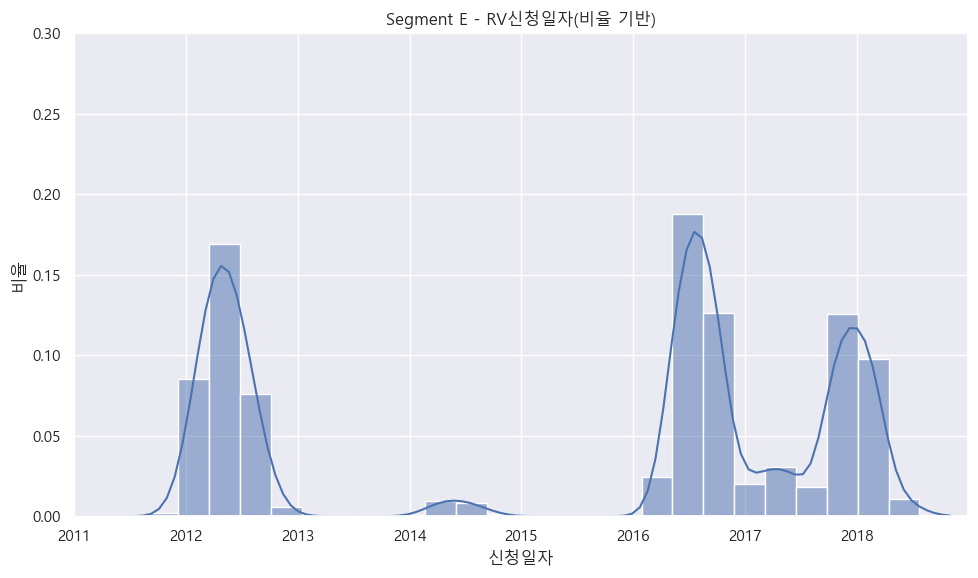

In [46]:
# RV신청일자 → datetime 타입으로 변환
df_all['RV신청일자'] = pd.to_datetime(df_all['RV신청일자'], format='%Y%m%d')


# Boxplot을 이용하여 Segment별 RV신청일자의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 RV신청일자
sns.boxplot(data=df_all, x='Segment', y='RV신청일자', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 RV신청일자")
plt.show()


# Segment별 히스토그램을 이용하여 CL이자율_할인전의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
x_min = datetime(2011, 1, 1)
x_max = datetime(2018, 12, 31)
y_min = 0
y_max = 0.3



for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='RV신청일자', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.ylim(y_min,y_max)
    plt.title(f"Segment {seg} - RV신청일자(비율 기반)")
    plt.xlabel("신청일자")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()

### 📊 'RV신청일자'만으로 특별한 흐름은 파악하기 어려움
- 'rv최초시작후경과일'과 함께 보면 좋을 듯

### ✅ 최초한도금액, 일시상환론한도금액 vs Segment 분포 비교

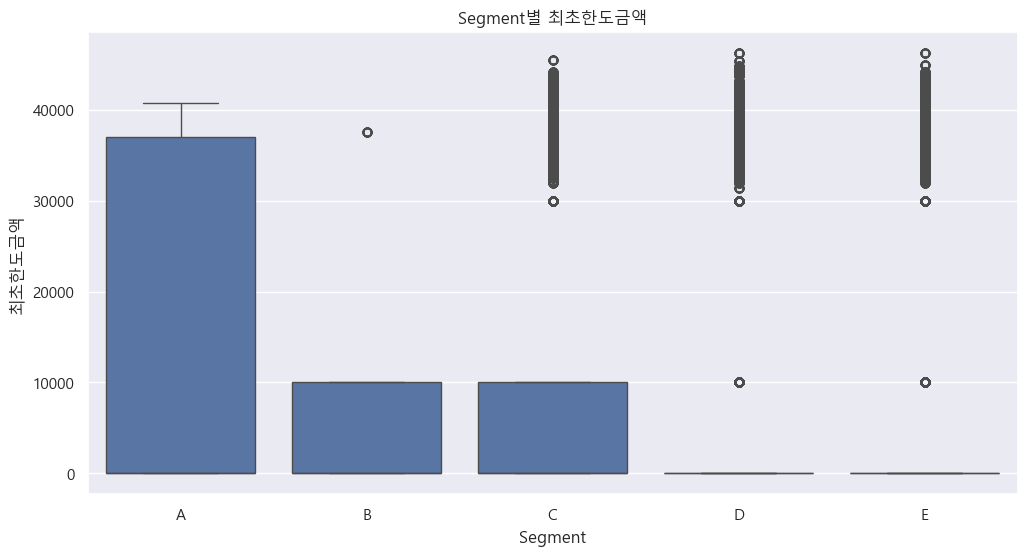

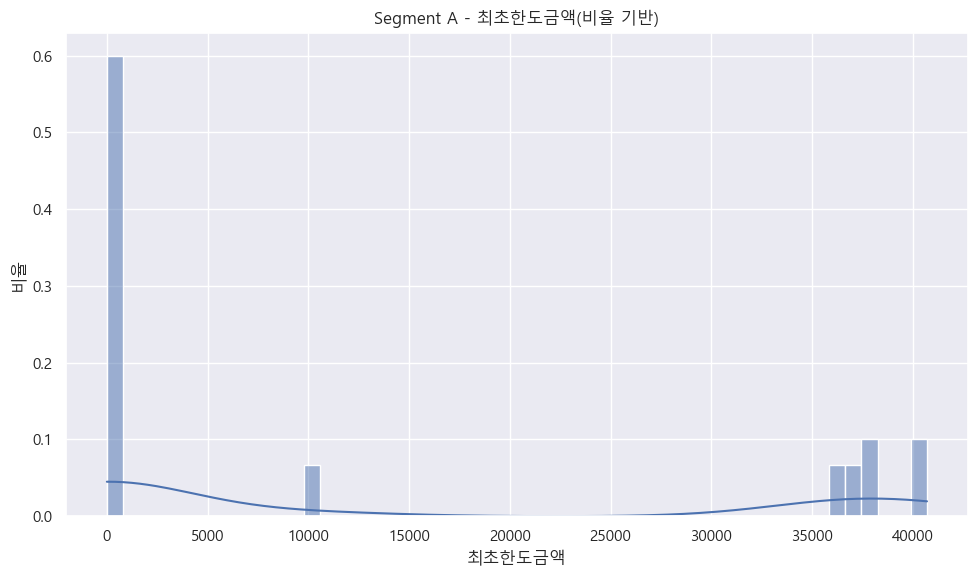

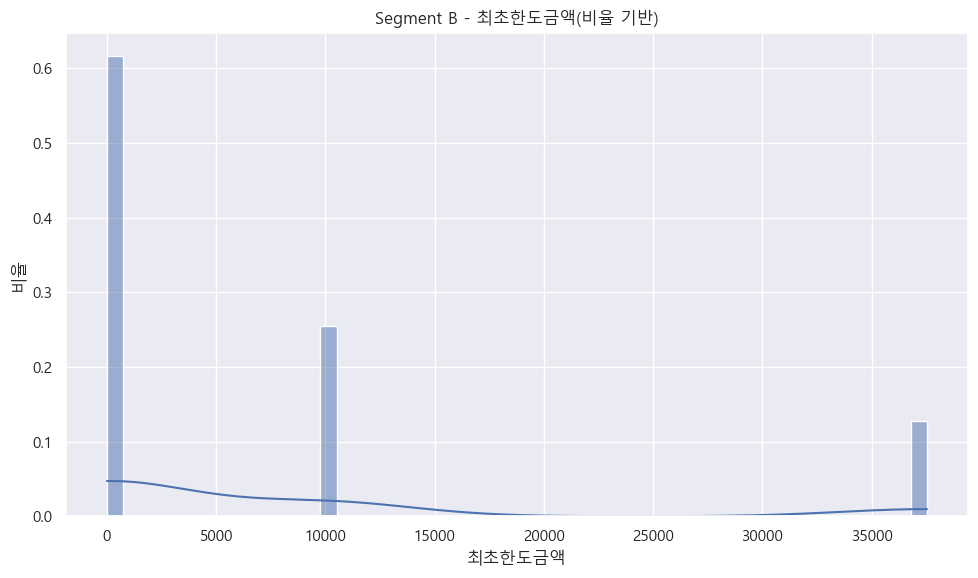

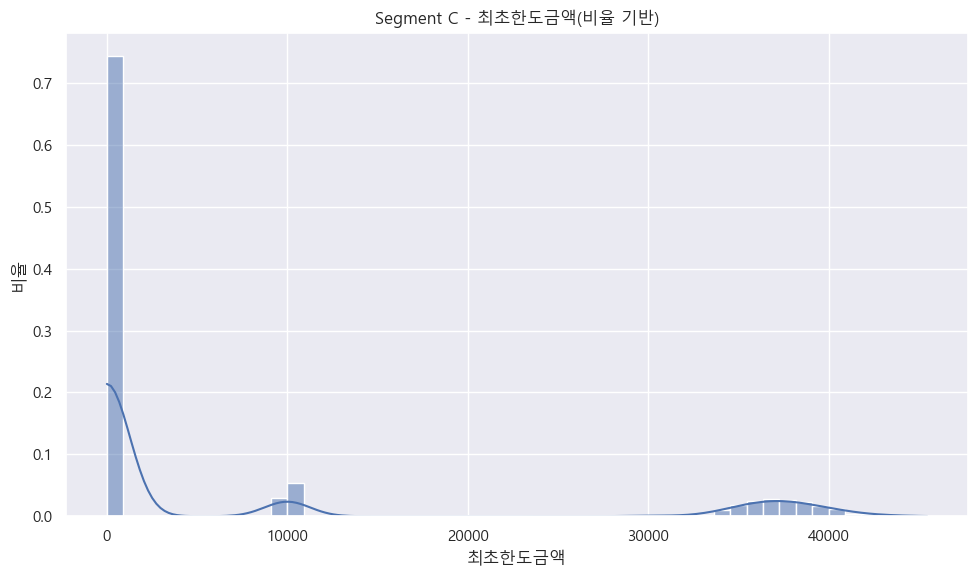

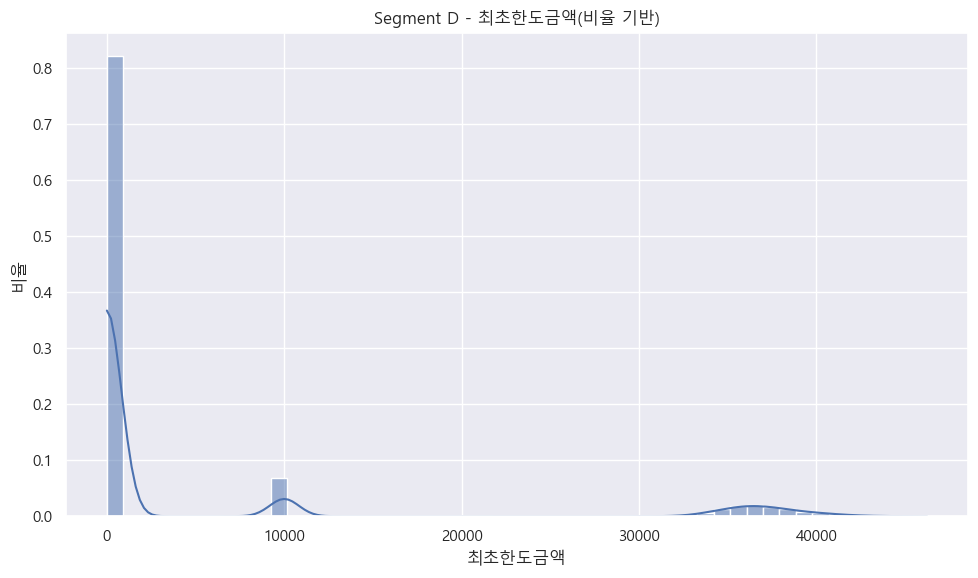

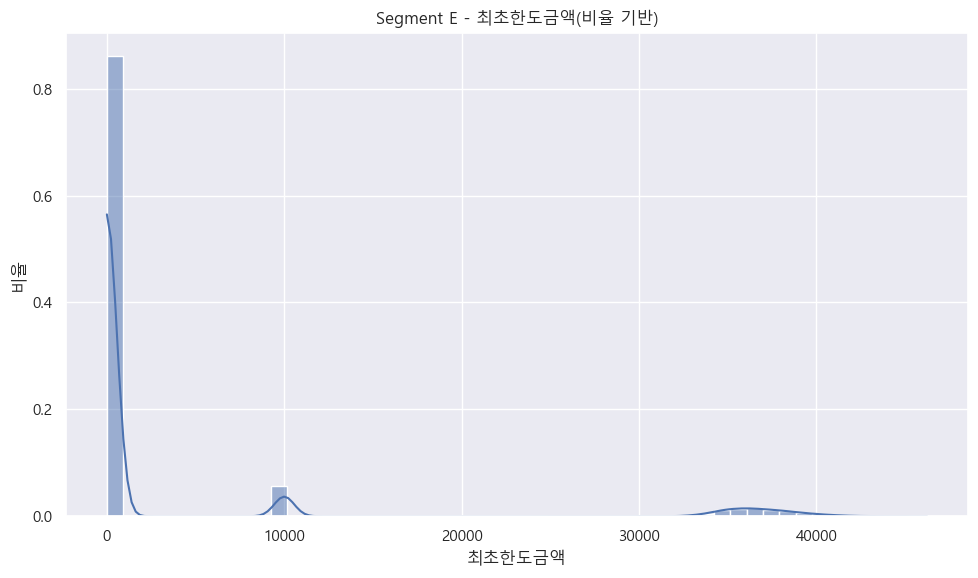

In [49]:
# Boxplot을 이용하여 Segment별 최초한도금액의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 CL이자율_할인전
sns.boxplot(data=df_all, x='Segment', y='최초한도금액', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 최초한도금액")
plt.show()


# Segment별 히스토그램을 이용하여 CL이자율_할인전의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='최초한도금액', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.title(f"Segment {seg} - 최초한도금액(비율 기반)")
    plt.xlabel("최초한도금액")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()

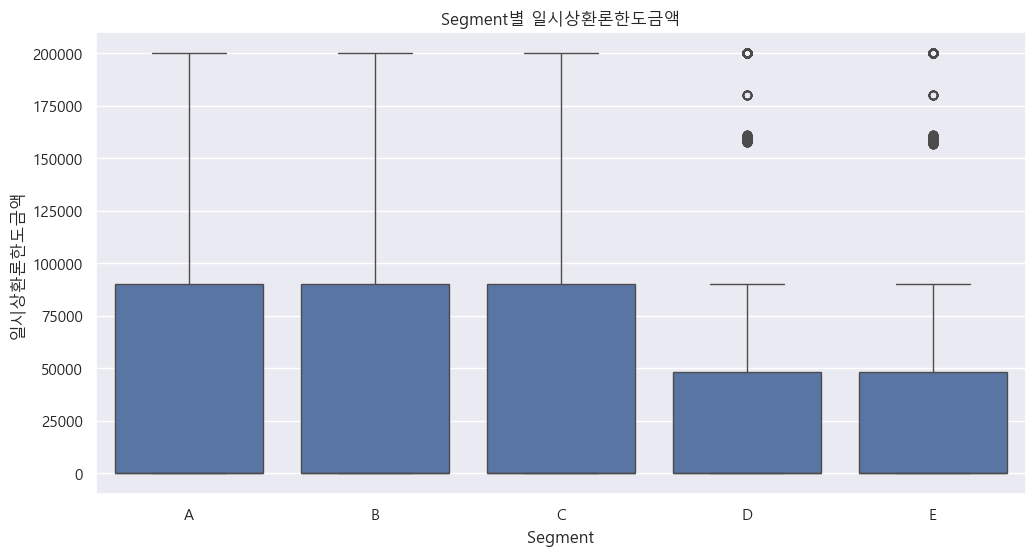

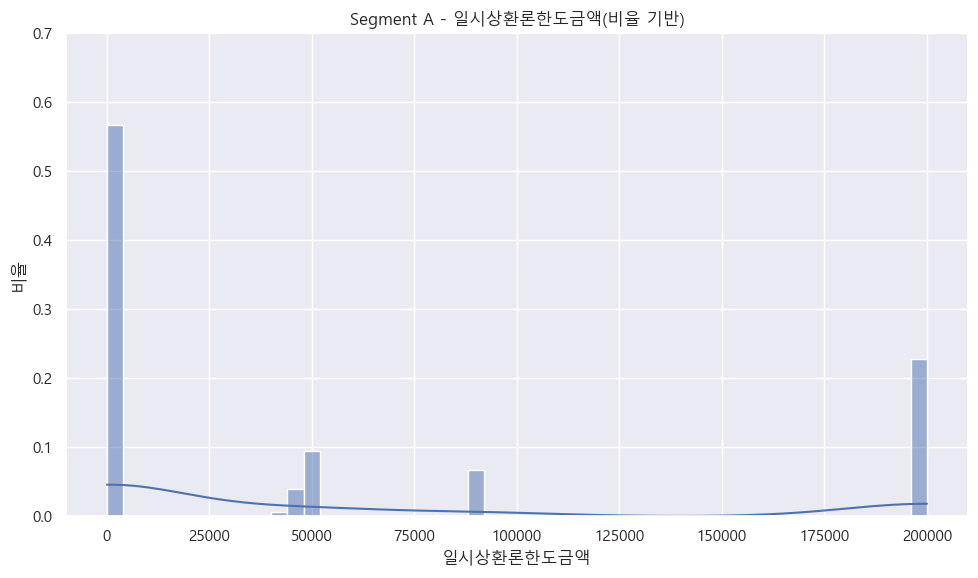

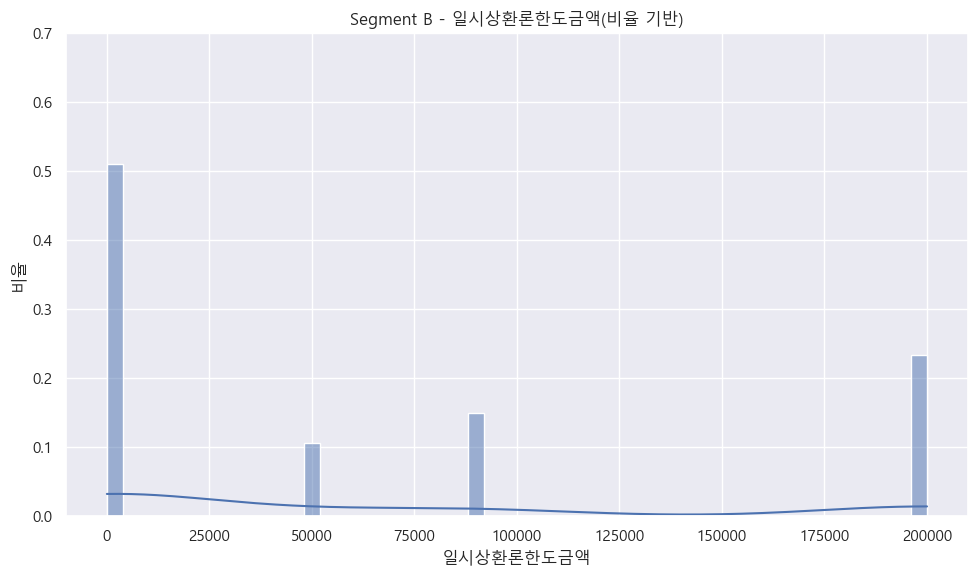

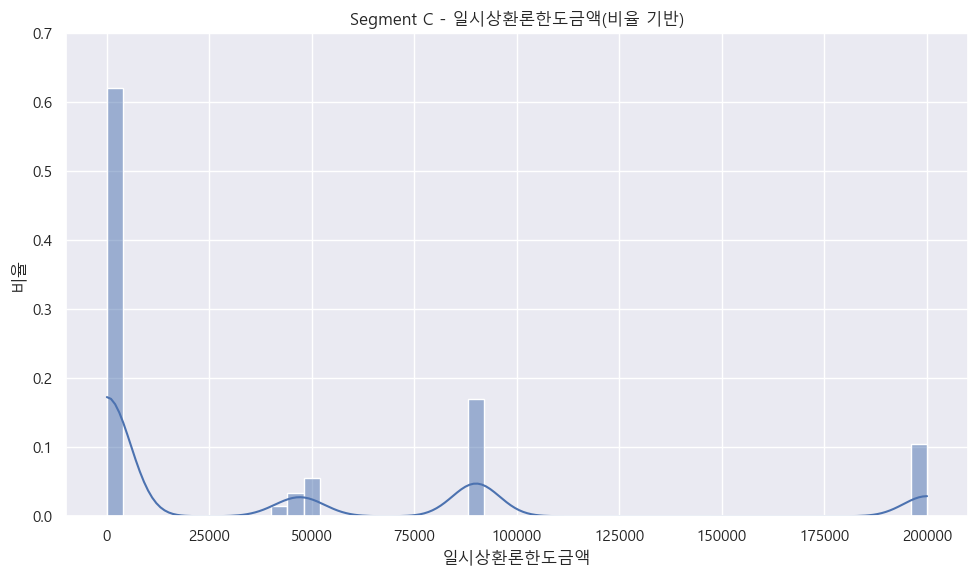

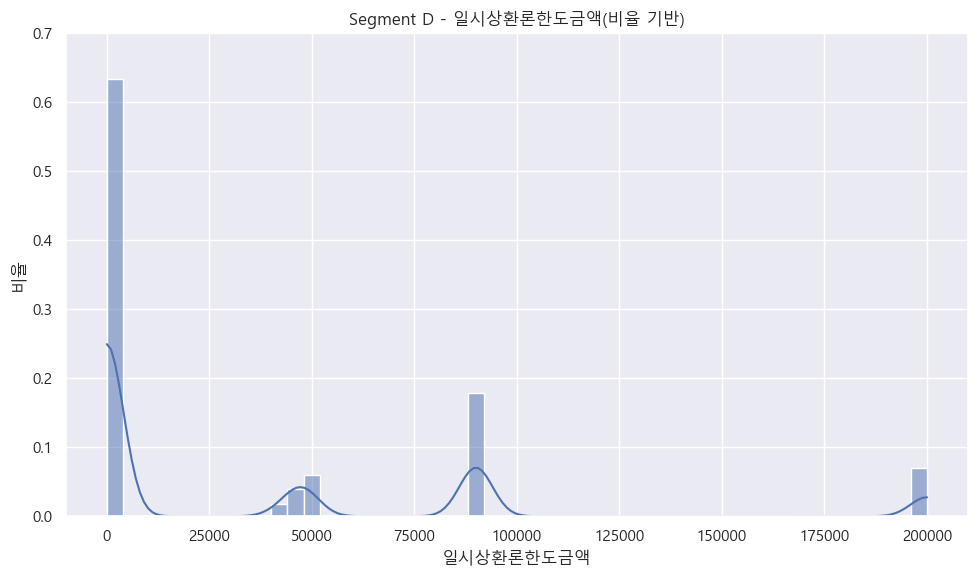

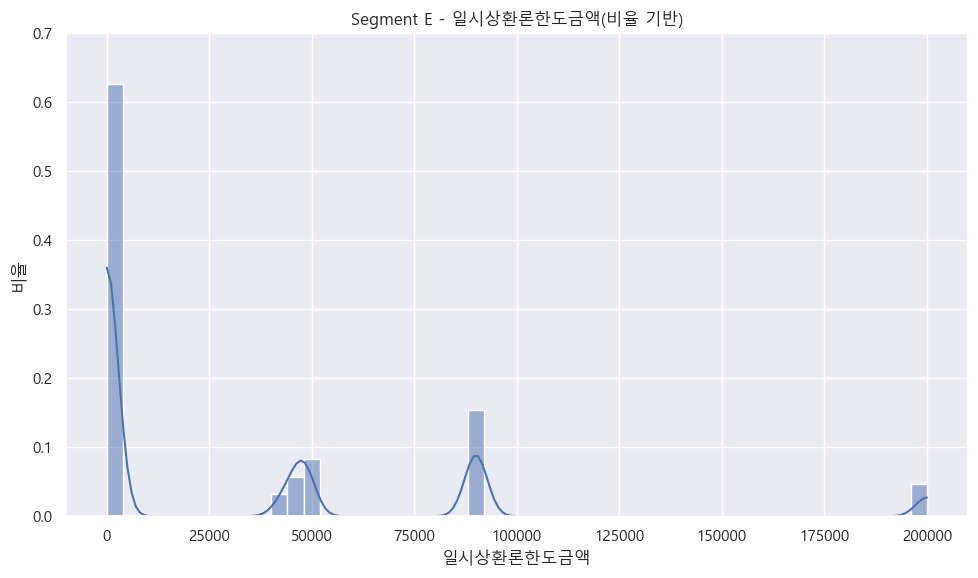

In [50]:
# Boxplot을 이용하여 Segment별 일시상환론한도금액의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 CL이자율_할인전
sns.boxplot(data=df_all, x='Segment', y='일시상환론한도금액', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 일시상환론한도금액")
plt.show()


# Segment별 히스토그램을 이용하여 CL이자율_할인전의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000
y_min = 0
y_max = 0.7


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='일시상환론한도금액', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.ylim(y_min,y_max)
    plt.title(f"Segment {seg} - 일시상환론한도금액(비율 기반)")
    plt.xlabel("일시상환론한도금액")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()

### 📊 최초한도금액, 일시상환론한도금은 전반적으로 이상치도 많고 특별한 흐름 파악 불가
- 제거

### ✅ 상향가능한도금액, RV약정청구율 vs Segment 분포 비교

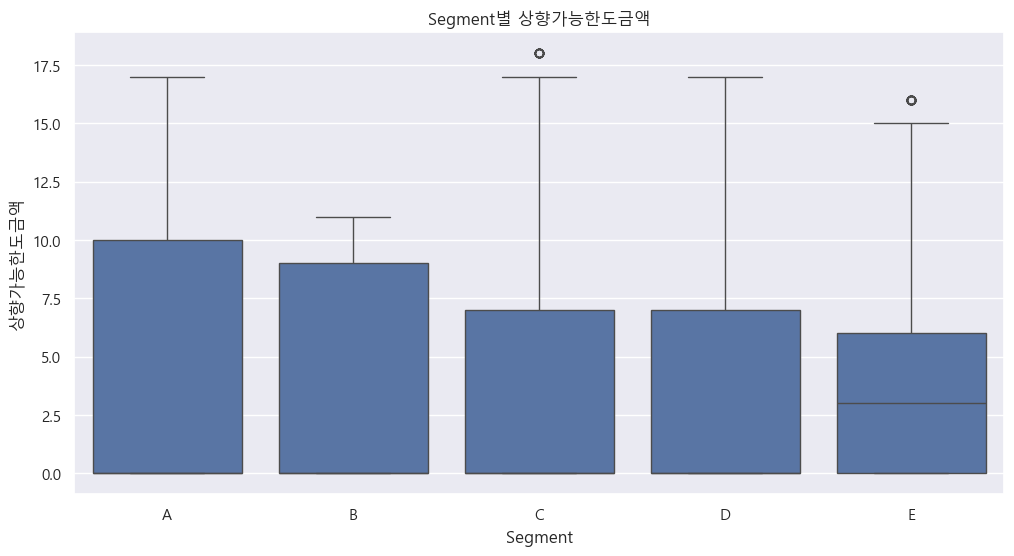

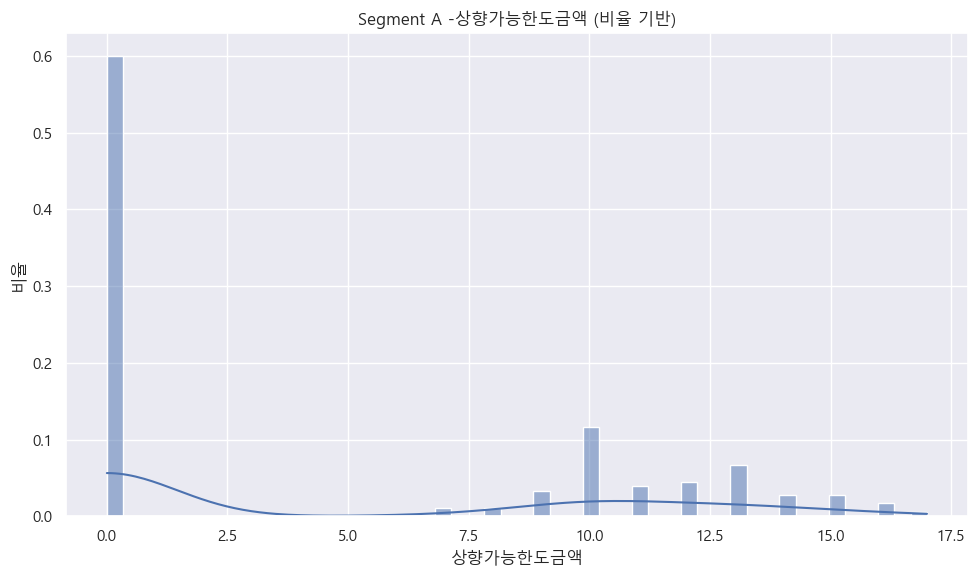

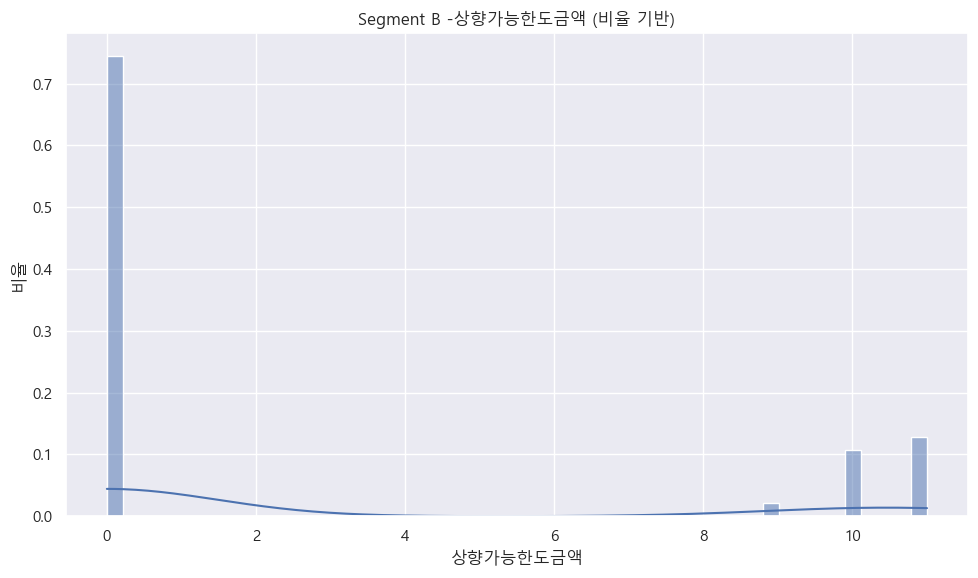

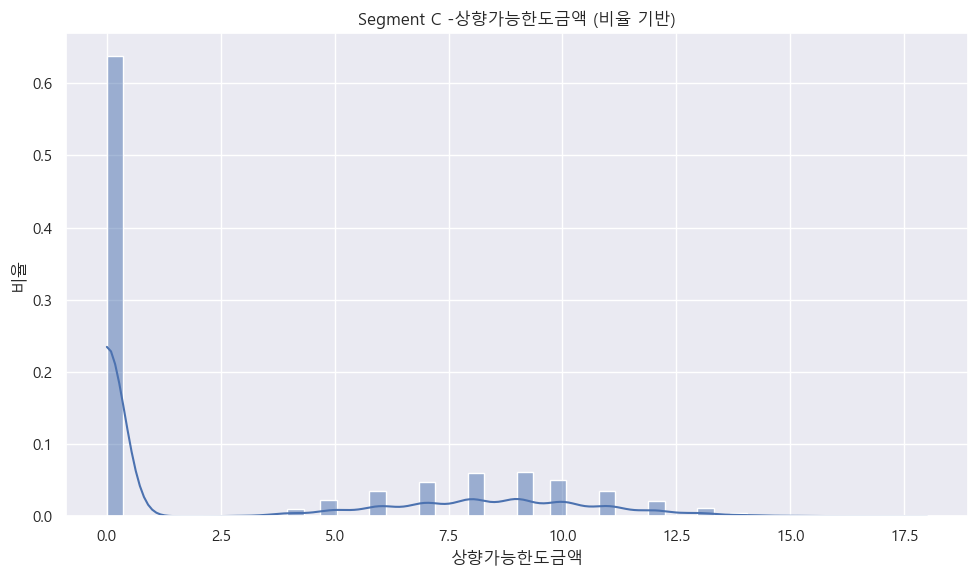

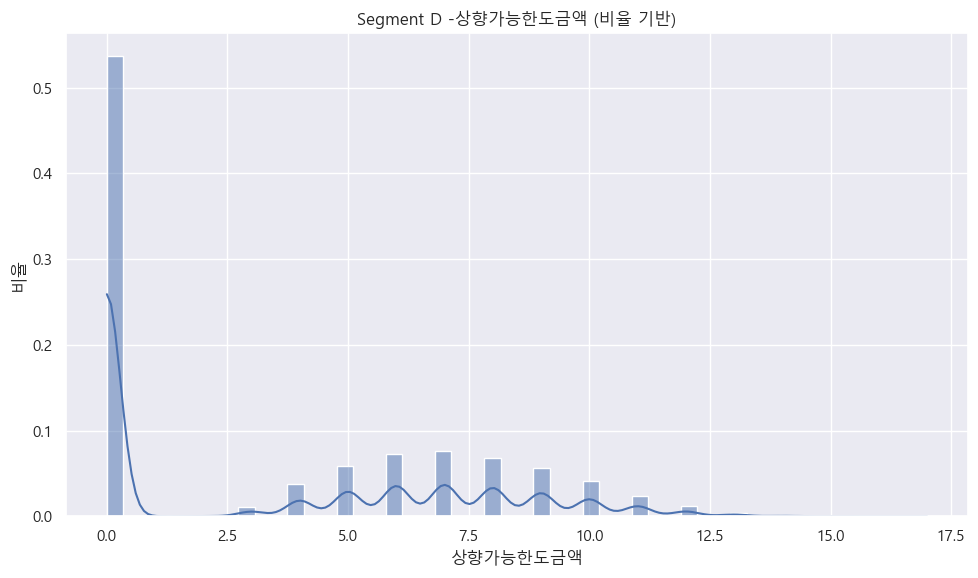

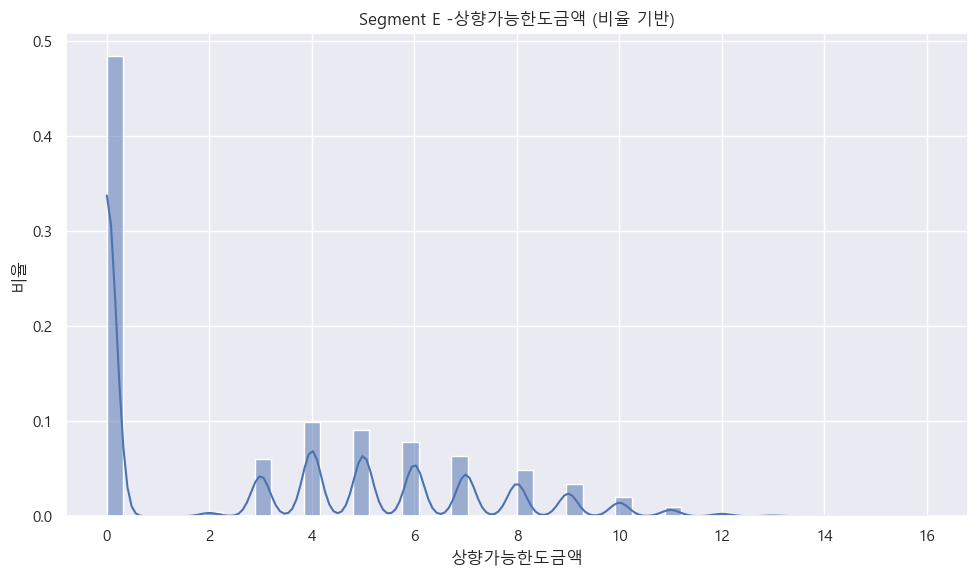

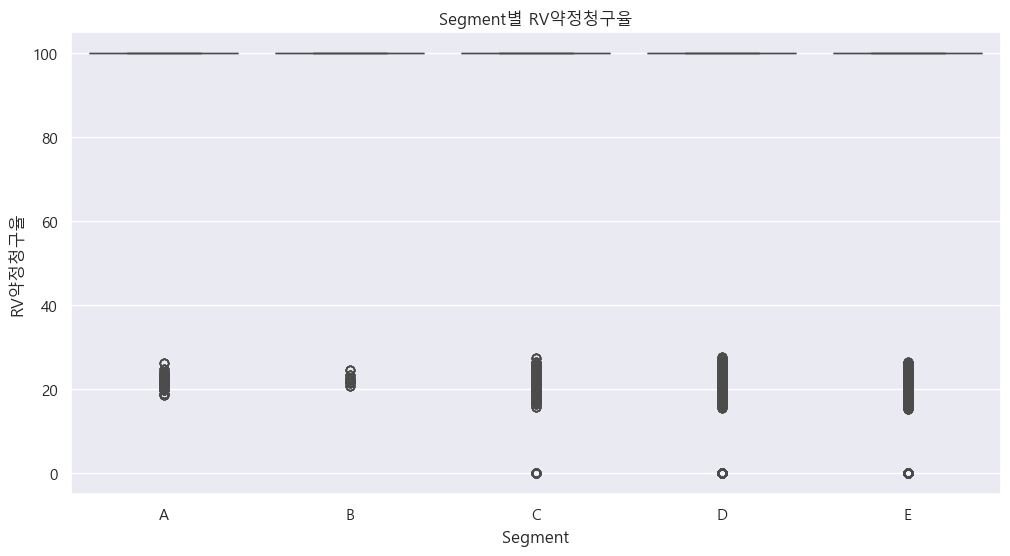

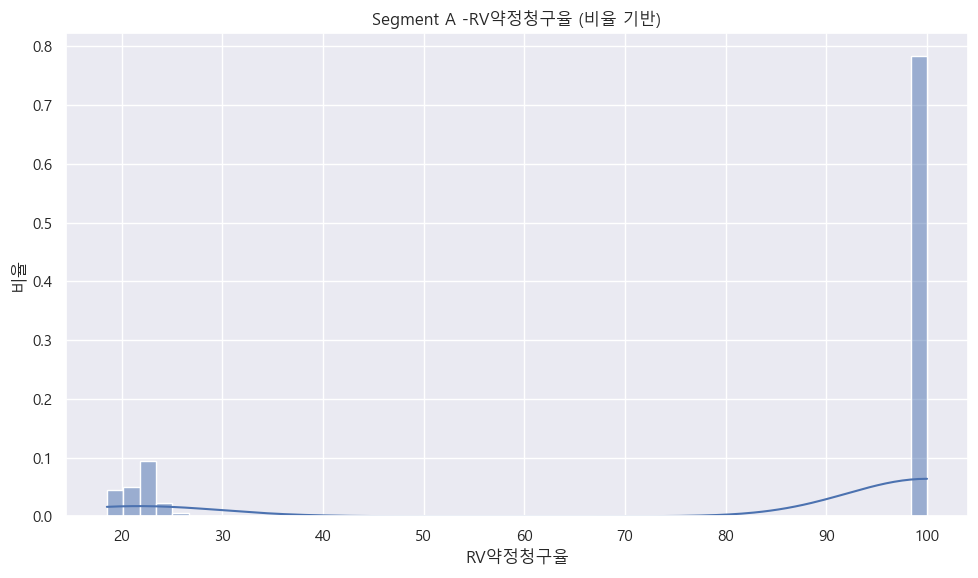

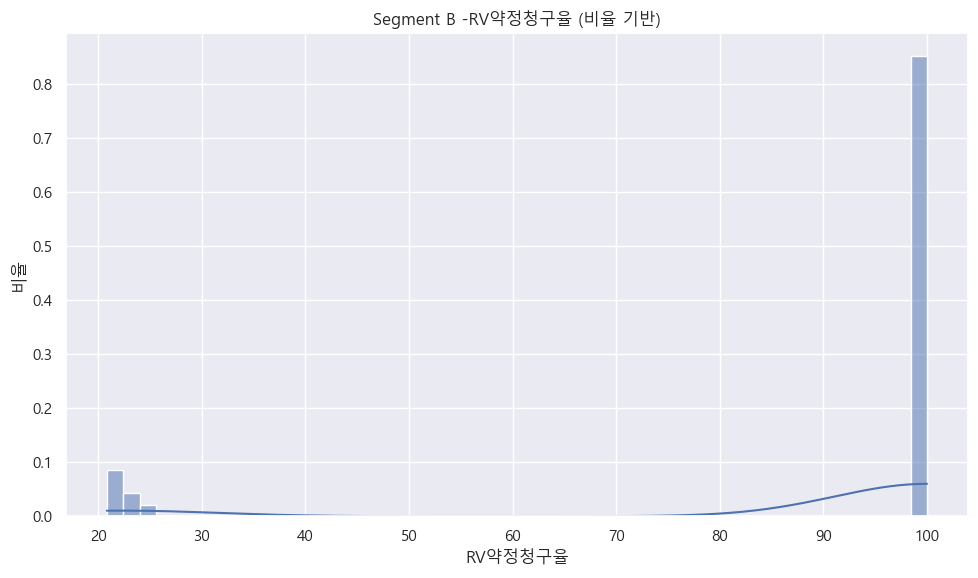

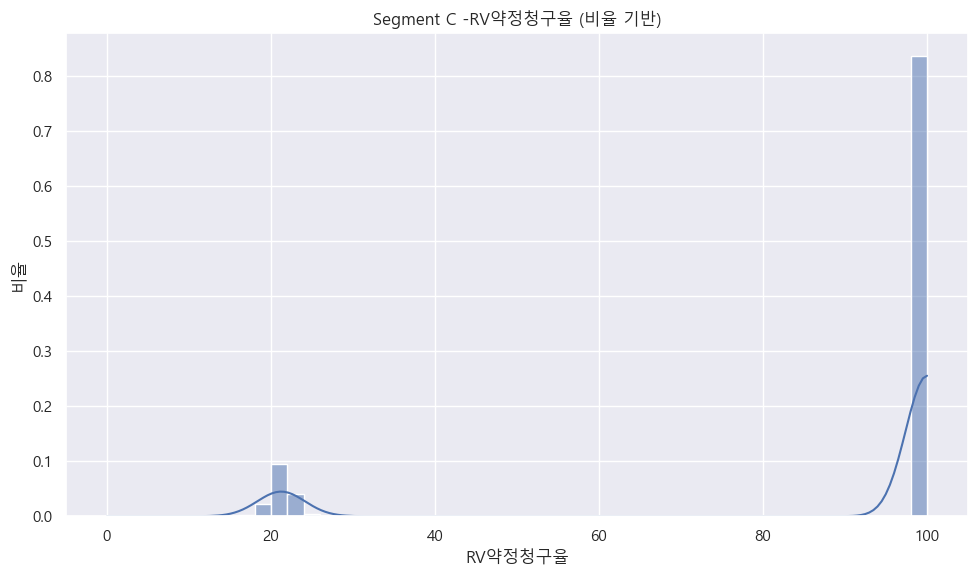

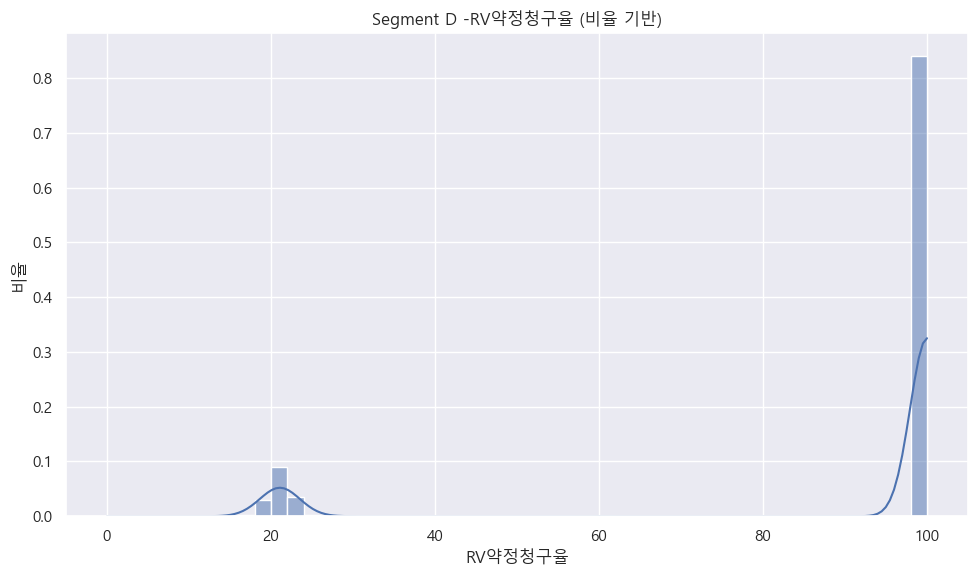

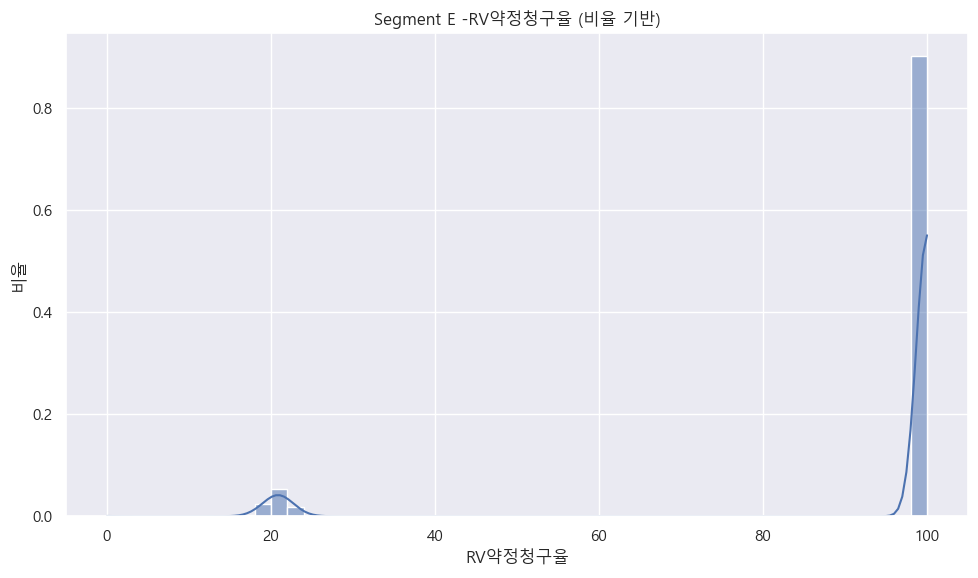

In [53]:
# Boxplot을 이용하여 Segment별 상향가능한도금액의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 CL이자율_할인전
sns.boxplot(data=df_all, x='Segment', y='상향가능한도금액', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 상향가능한도금액")
plt.show()


# Segment별 히스토그램을 이용하여 상향가능한도금액의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='상향가능한도금액', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.title(f"Segment {seg} -상향가능한도금액 (비율 기반)")
    plt.xlabel("상향가능한도금액")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()

#______________________________________________

# Boxplot을 이용하여 Segment별 RV약정청구율의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 RV약정청구율
sns.boxplot(data=df_all, x='Segment', y='RV약정청구율', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 RV약정청구율")
plt.show()


# Segment별 히스토그램을 이용하여 RV약정청구율의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='RV약정청구율', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.title(f"Segment {seg} -RV약정청구율 (비율 기반)")
    plt.xlabel("RV약정청구율")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()

### 📊 세그먼트 A와 E, 두 세그먼트의 RV약정청구율, 상향가능한도금액 패턴이 조금 다름

- 세그먼트 E에 비해 A 그룹의 고객이 이질적 특성을 가지고 있다고 보임

### ✅ '상향가능CA한도금액', 'RV최소결제비율', '한도증액후경과월', '강제한도감액후경과월' vs Segment 분포 비교

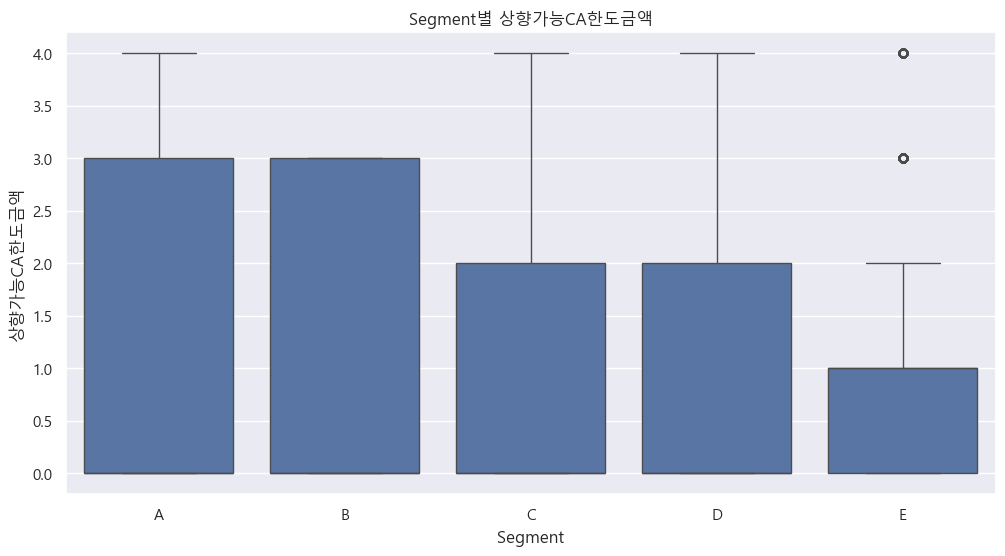

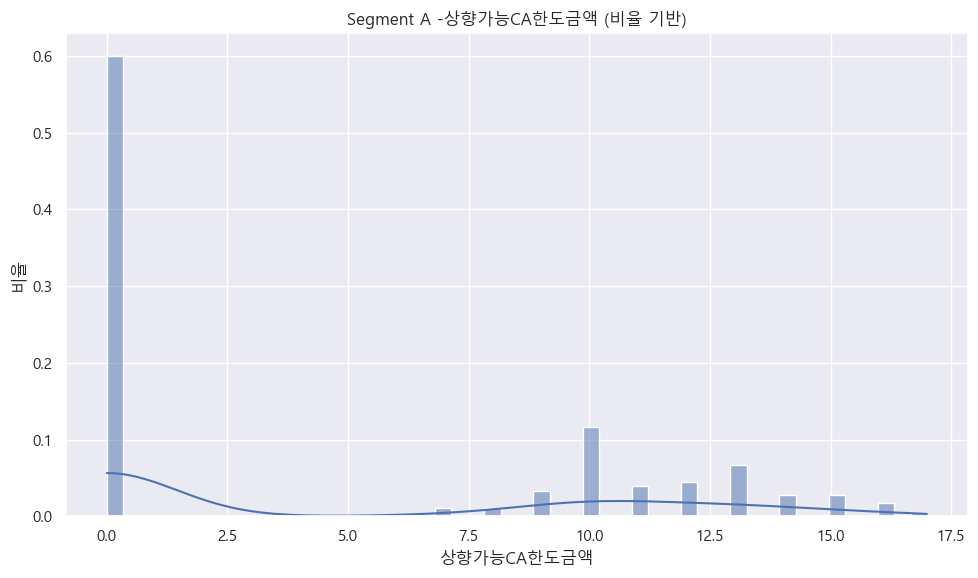

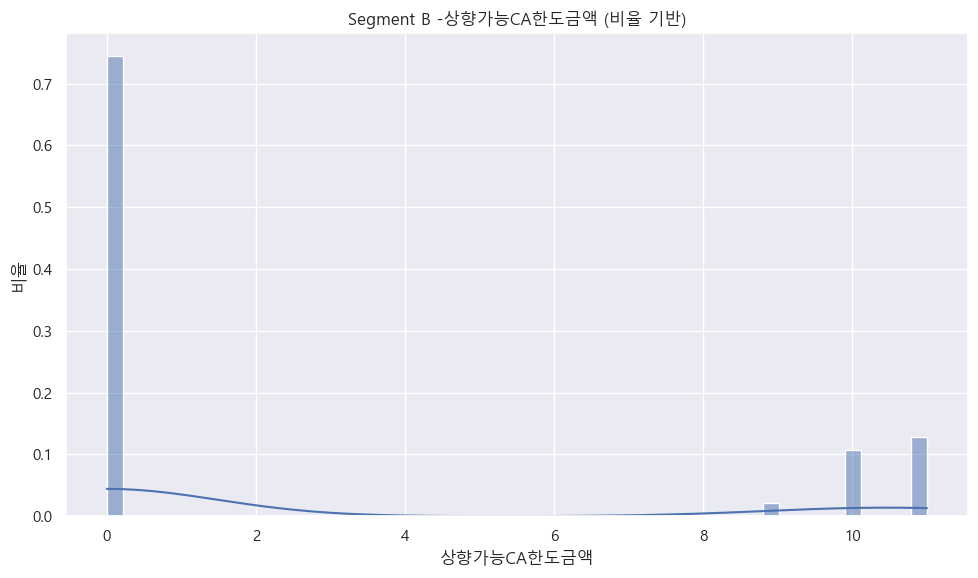

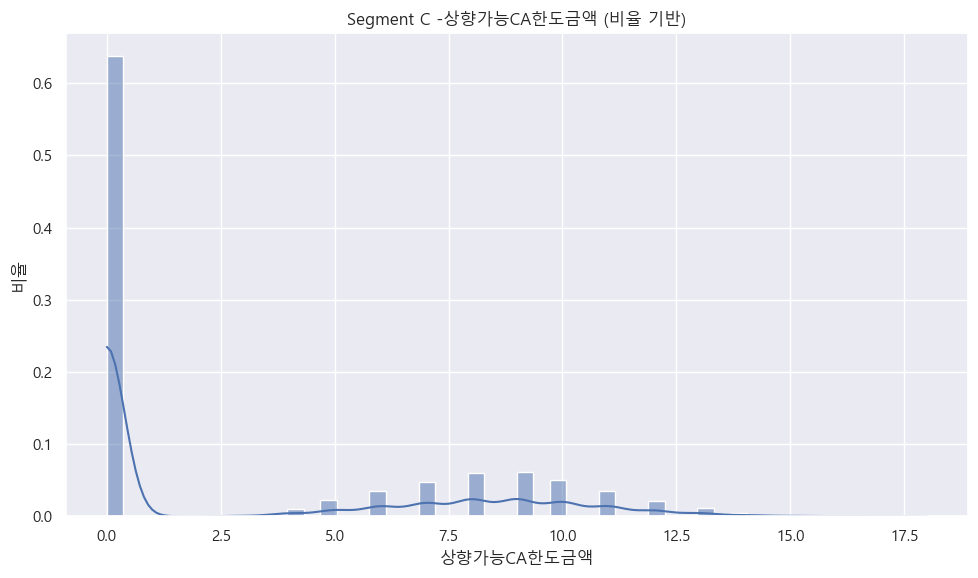

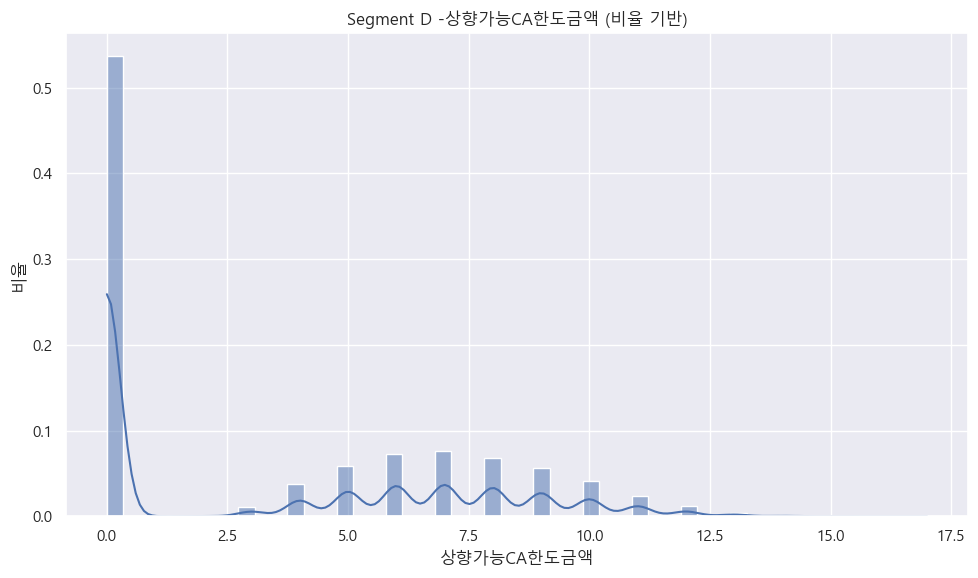

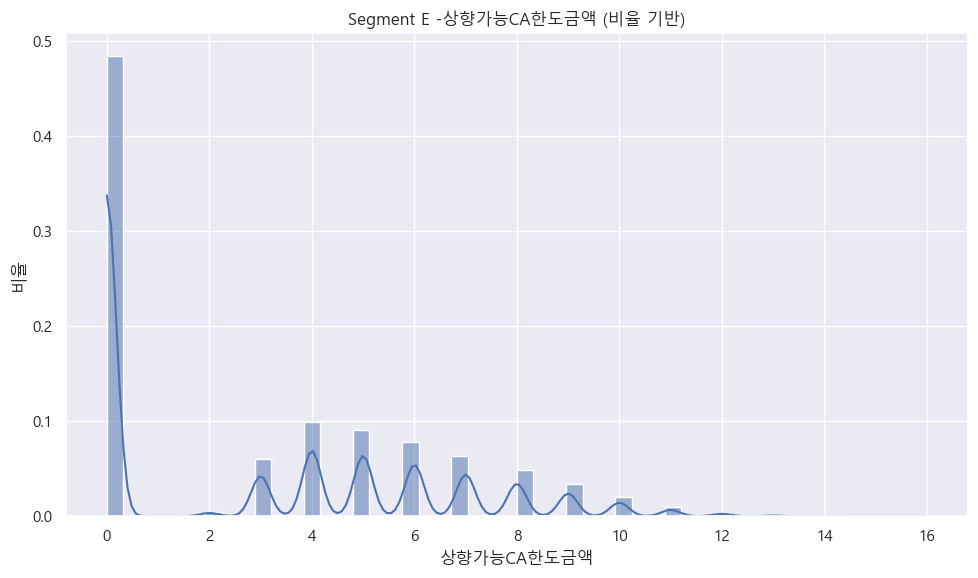

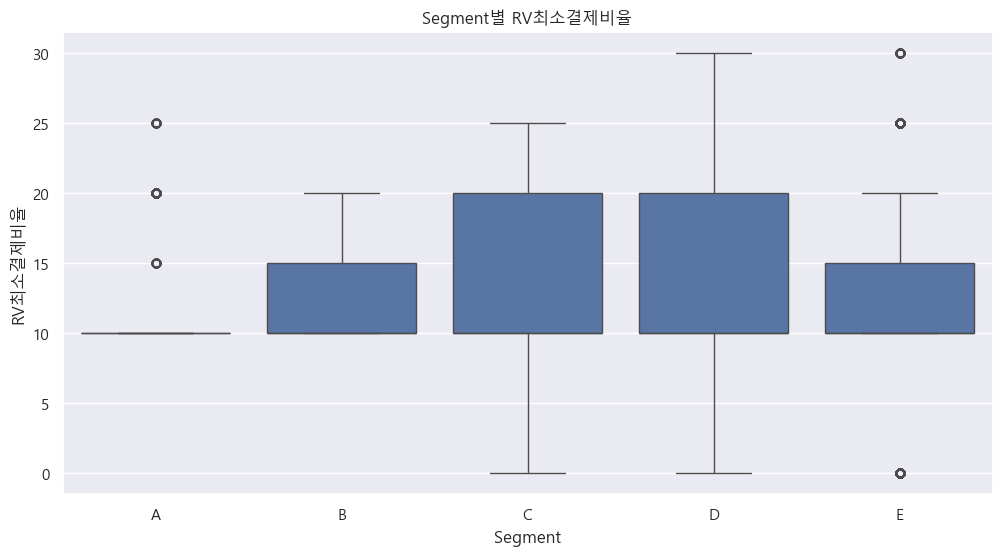

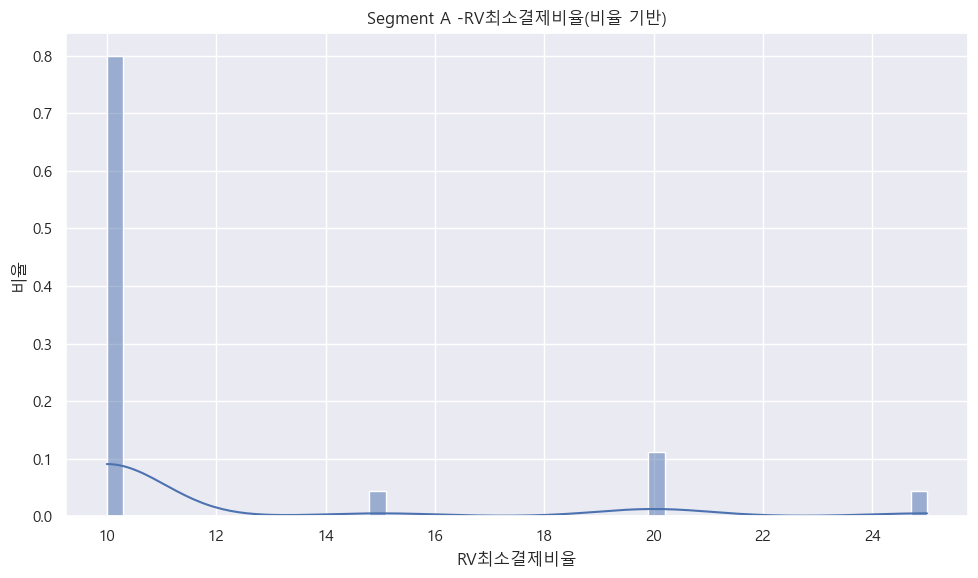

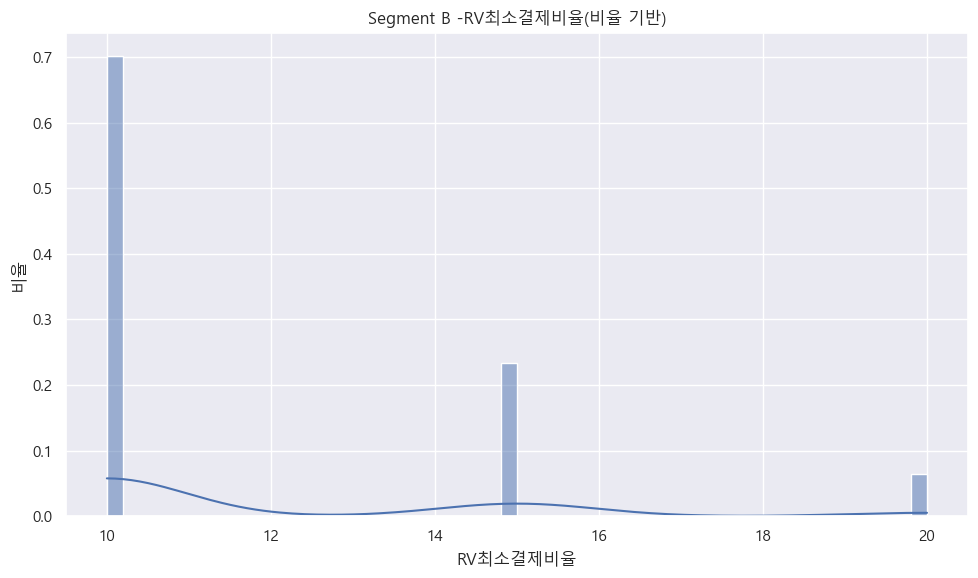

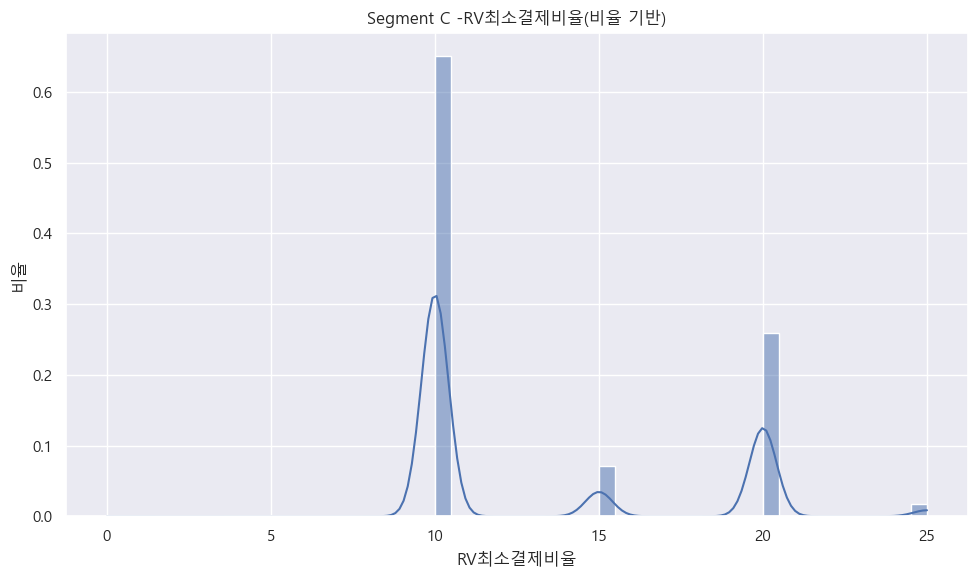

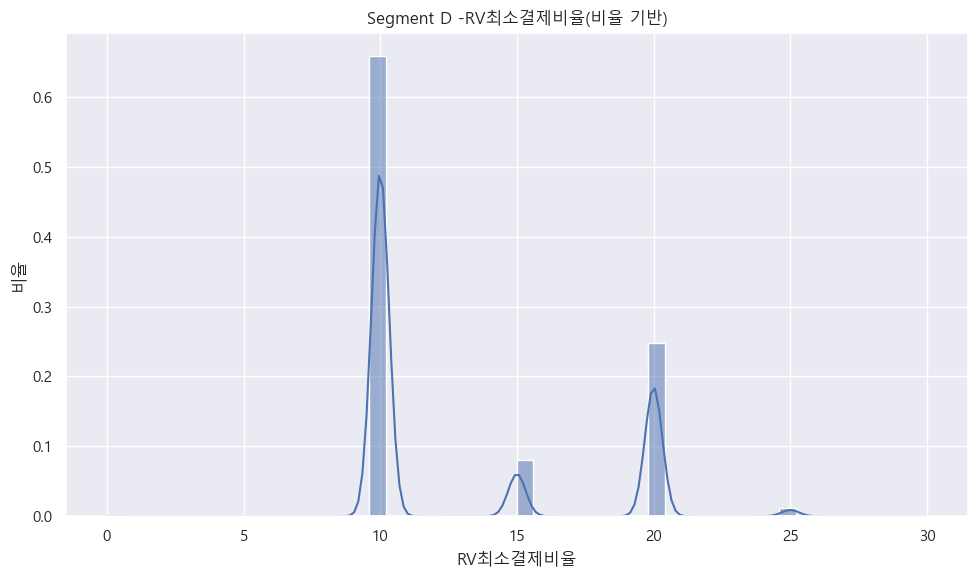

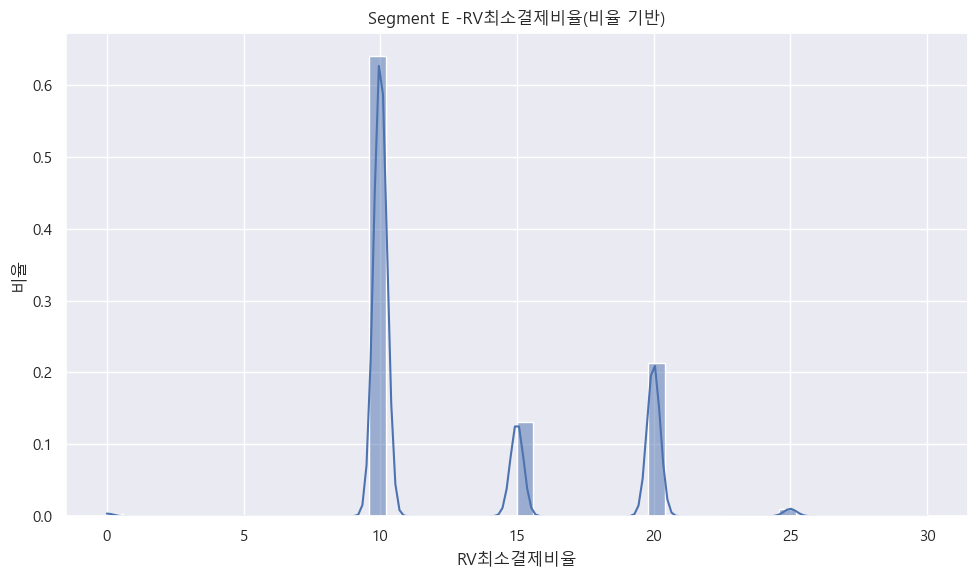

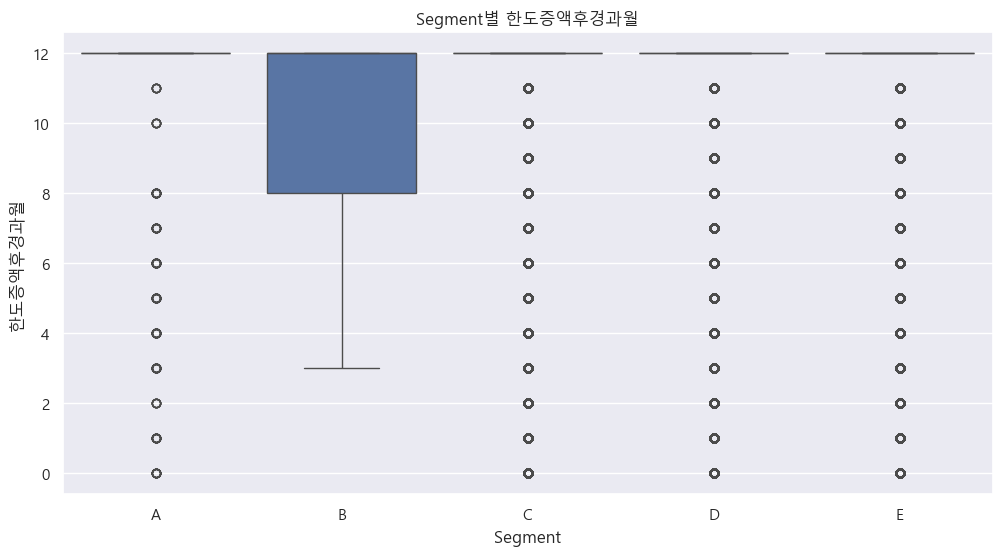

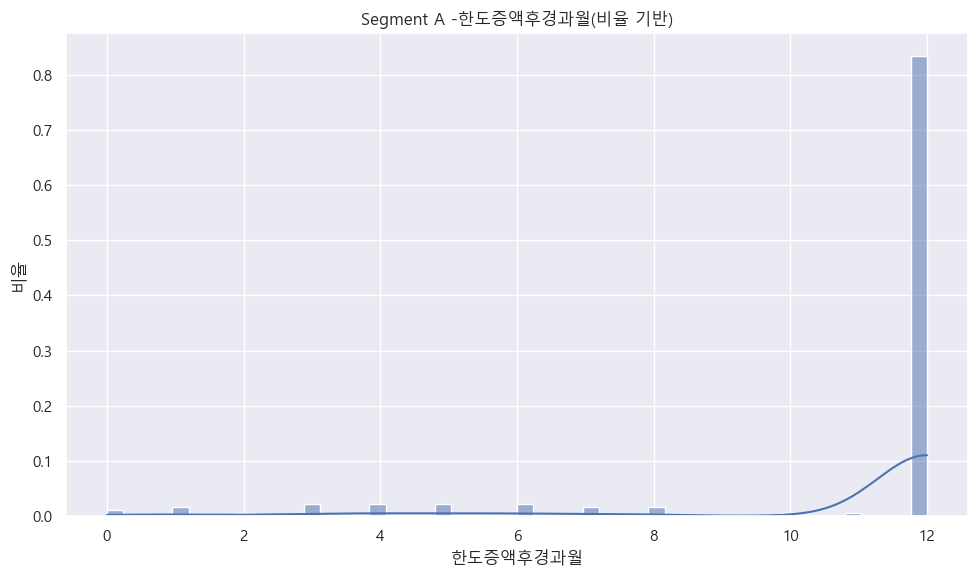

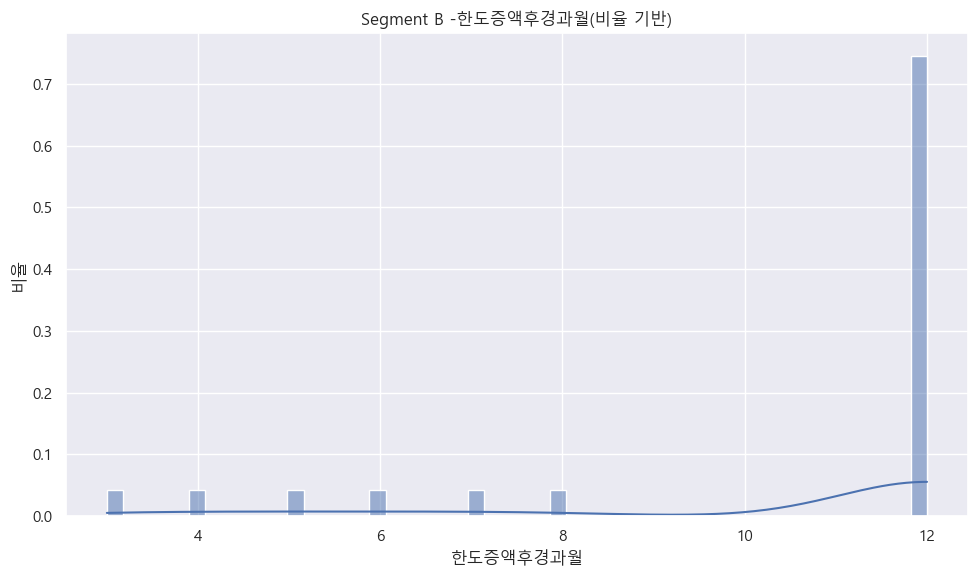

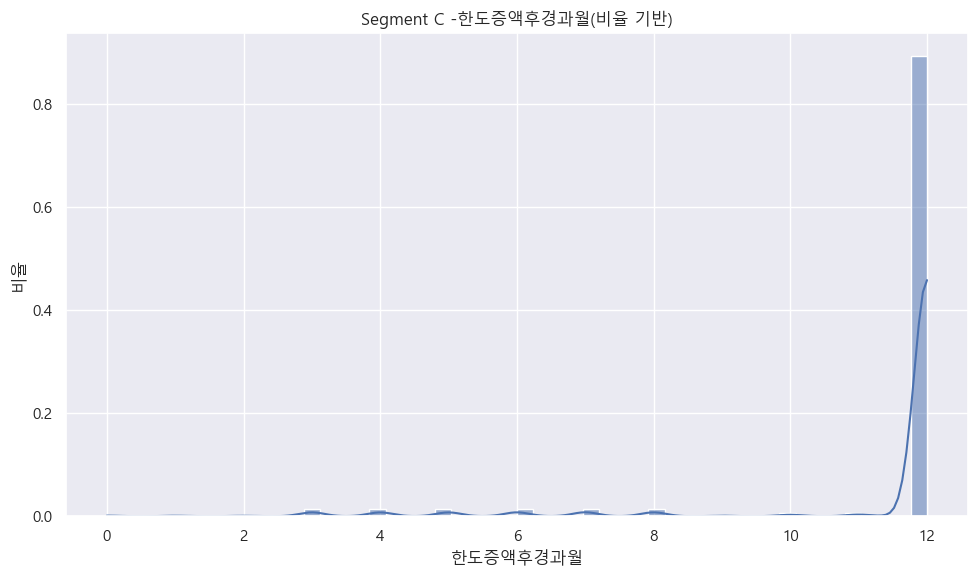

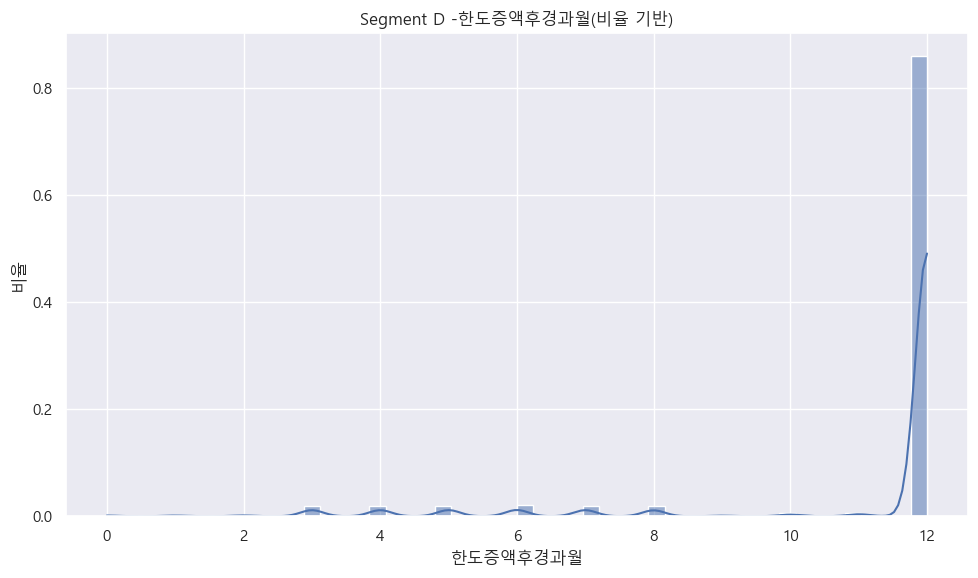

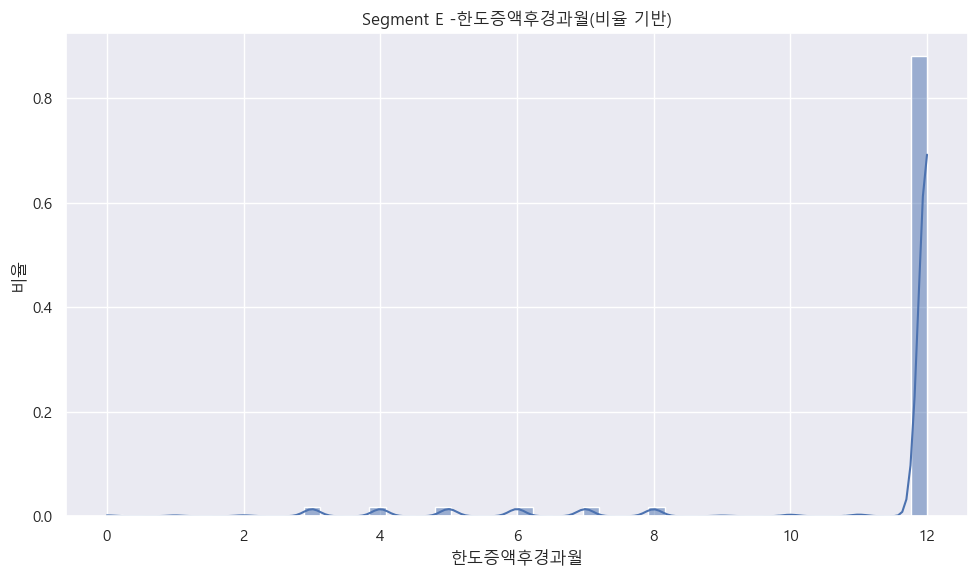

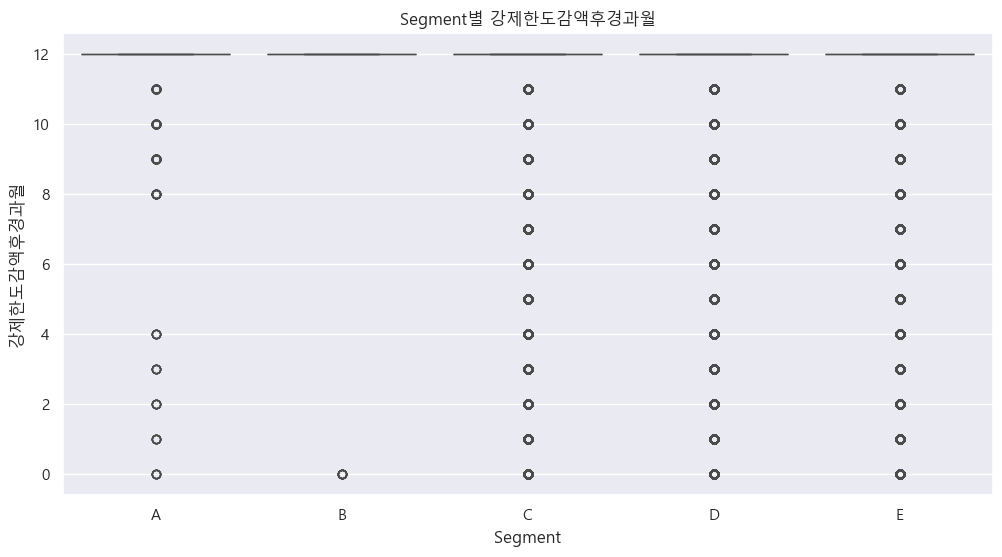

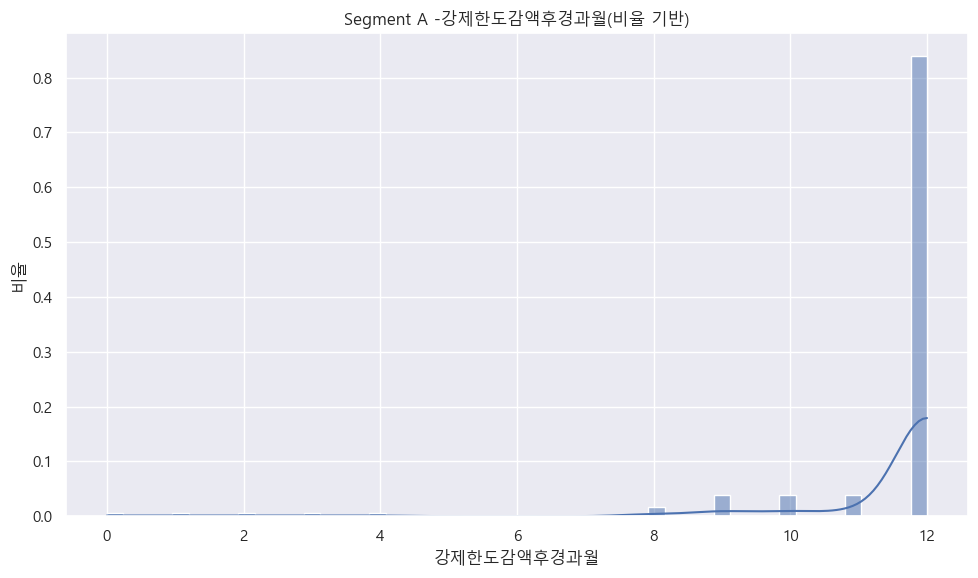

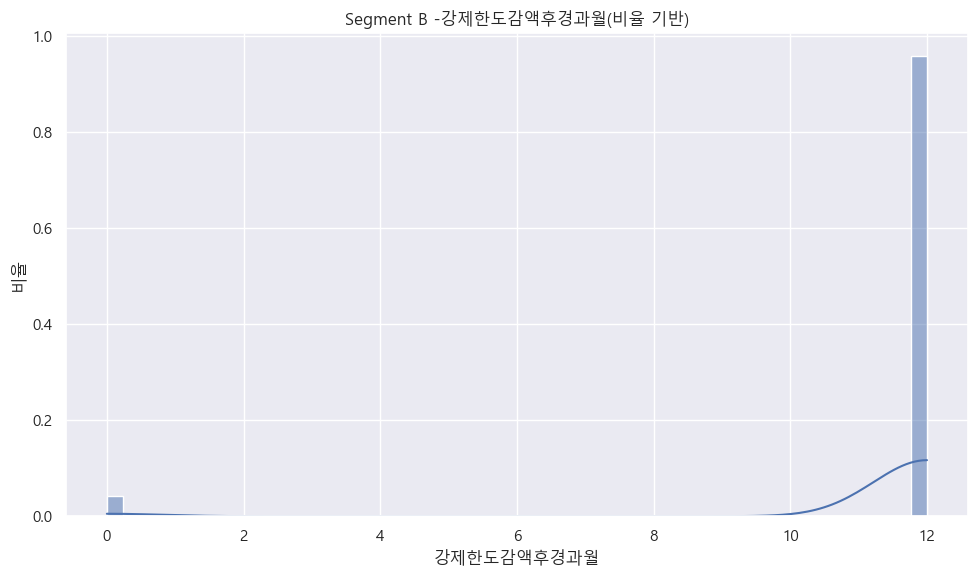

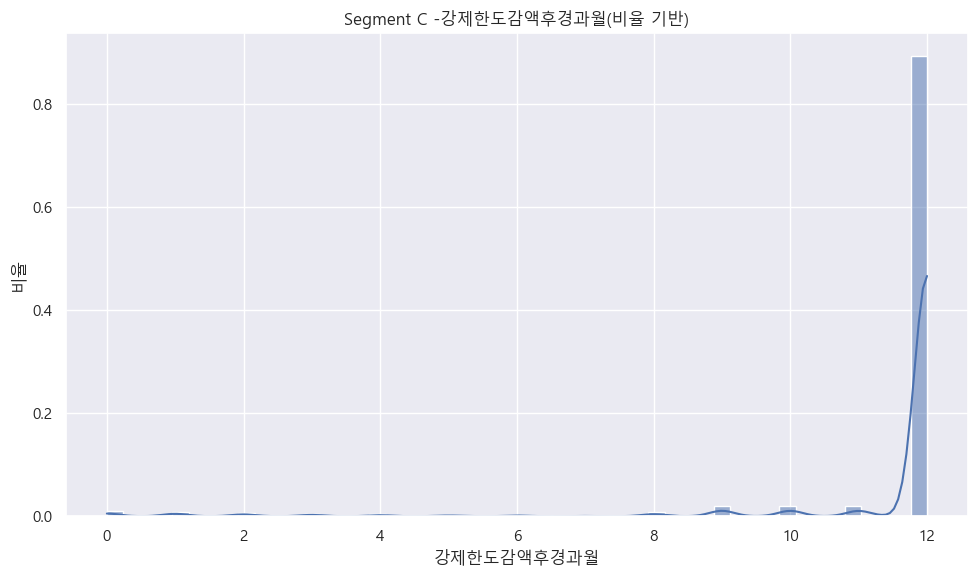

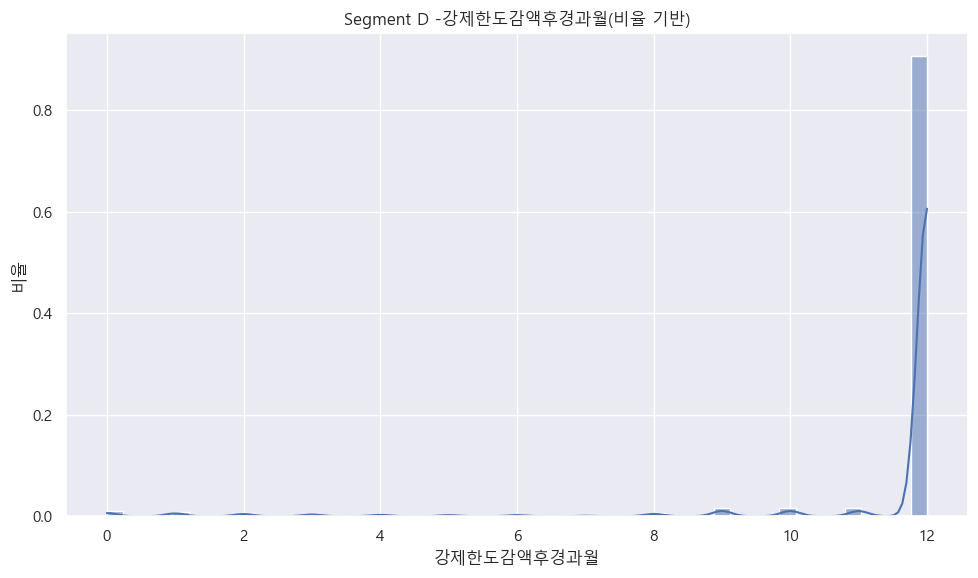

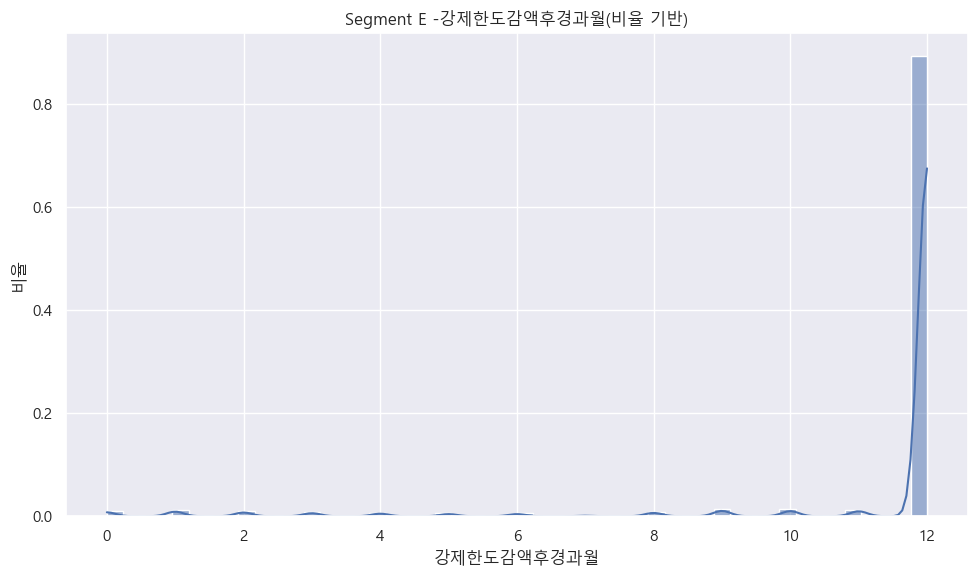

In [56]:
# Boxplot을 이용하여 Segment별 상향가능CA한도금액의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 상향가능CA한도금액
sns.boxplot(data=df_all, x='Segment', y='상향가능CA한도금액', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 상향가능CA한도금액")
plt.show()


# Segment별 히스토그램을 이용하여 상향가능CA한도금액의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='상향가능한도금액', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.title(f"Segment {seg} -상향가능CA한도금액 (비율 기반)")
    plt.xlabel("상향가능CA한도금액")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()

#______________________________________________RV최소결제비율


# Boxplot을 이용하여 Segment별 RV최소결제비율의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 RV최소결제비율
sns.boxplot(data=df_all, x='Segment', y='RV최소결제비율', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 RV최소결제비율")
plt.show()


# Segment별 히스토그램을 이용하여 RV최소결제비율의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='RV최소결제비율', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.title(f"Segment {seg} -RV최소결제비율(비율 기반)")
    plt.xlabel("RV최소결제비율")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()
#______________________________________________한도증액후경과월



# Boxplot을 이용하여 Segment별 한도증액후경과월의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 한도증액후경과월
sns.boxplot(data=df_all, x='Segment', y='한도증액후경과월', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 한도증액후경과월")
plt.show()


# Segment별 히스토그램을 이용하여 RV최소결제비율의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='한도증액후경과월', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.title(f"Segment {seg} -한도증액후경과월(비율 기반)")
    plt.xlabel("한도증액후경과월")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()


#______________________________________________강제한도감액후경과월



# Boxplot을 이용하여 Segment별 강제한도감액후경과월의 분포 비교
# Segment A, B, C, D, E 라는 다섯 그룹이 존재
# x축은 세그먼트 y축은 강제한도감액후경과월
sns.boxplot(data=df_all, x='Segment', y='강제한도감액후경과월', order=['A', 'B', 'C', 'D', 'E'])

# 박스 플롯의 제목
plt.title("Segment별 강제한도감액후경과월")
plt.show()


# Segment별 히스토그램을 이용하여 강제한도감액후경과월의 분포 비교

segments = ['A', 'B', 'C', 'D', 'E']

# x축 공통 범위 설정 (원하는 범위로 조정)
# 모든 그래프를 같은 기준으로 비교하기 위함
# x_min = 0
# x_max = 250000


for seg in segments:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_all[df_all['Segment'] == seg], 
                 x='강제한도감액후경과월', bins=50, kde=True,
                 stat='probability')  # ✅ 빈도 → 비율'


    # plt.xlim(x_min, x_max)  # ← 공통 범위로 고정
    plt.title(f"Segment {seg} -강제한도감액후경과월(비율 기반)")
    plt.xlabel("강제한도감액후경과월")
    plt.ylabel("비율")
    plt.tight_layout()
    plt.show()

### 📊 상향가능CA한도금액 큰 차이는 없음
- 세그먼트 E로 갈수록 신규 고객층에서도 소수는 일정 수준의 상향 가능성이 존재.
####
### 📊 RV최소결제비율 명확하게 해석할 흐름은 없음
- 다만 세그먼트 D, E에서 A~C와 다르게 0, 30값이 존재하는 것으로 확인
####
### 📊 '한도증액후경과월', '강제한도감액후경과월'은 세그먼트와 무관하게 12개월로 몰림
- 제거

## 💾 데이터 추출

In [59]:
# 모든 parquet 파일 다시 불러오기
# 데이터분석을 위해 결측이 있는 행을 제거했는데 카테고리별 파일 병합을 위해 다시 원본 데이터를 불러옴
file_list = glob.glob("C:/Users/user/Desktop/workspace/14_Final_PROJECT/open/train/2.신용정보/*.parquet")

df_all = pd.DataFrame()

for file in file_list:
    temp = pd.read_parquet(file)
    df_all = pd.concat([df_all, temp], ignore_index=True)

In [60]:
# ID, 기준년월 포함한 선택 피처
features_to_keep = [
    'ID', '기준년월',
    '카드이용한도금액', 'CA이자율_할인전', 'rv최초시작후경과일', 'CL이자율_할인전', 'RV신청일자',
    '상향가능한도금액', 'RV약정청구율', '상향가능CA한도금액', 'RV최소결제비율'
]

# 데이터 필터링
df_category1 = df_all[features_to_keep]

# CSV 저장
df_category1.to_csv("02_신용정보_selected.csv", index=False, encoding='utf-8-sig')